### **Note on Confidentiality**

This project was completed as part of my course at the University of Cambridge. To comply with academic policy, the raw dataset has been excluded and all specific identifiers have been anonymized. This notebook serves to demonstrate the analytical methodology.

### Data Preparation

All the necessary libraries are installed here

In [ ]:
# It installs the latest sktime and all its certified dependencies.
!pip install -q --upgrade \
  "sktime[all_extras]" \
  tensorflow \
  keras-tuner \
  hyperopt \
  xlrd \
  openpyxl

# Automatically restart runtime after installation
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 585.3/645.0 MB 5.8 MB/s eta 0:00:11
ERROR: Operation cancelled by user


All the necessary packages are imported here

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib import rc
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels.graphics.api as smgraphics

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings

from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima

import joblib

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


# Load the relevant helper functions from sktime.
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, ForecastingGridSearchCV)
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

from xgboost import XGBRegressor

# Import the package for hyperparameter tuning.
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt import hp, STATUS_OK
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Import the relevant libraries.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

!pip install keras-tuner --upgrade -q
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import BayesianOptimization

/tmp/ipython-input-2942279946.py:59: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Datasets are imported using *gdown* and saved into dictionary variables to account for the separate sheets. In the cell below, sheets are merged into a single *pandas* DataFrame for each dataset. Due to confidentiality reason, the URL of the original dataset is not included.

In [ ]:
# Google Drive file IDs (Extract these manually or via API)
uk_weekly_trend_id = ''  # Replace with the actual file ID
IBSN_list_id = ''  # Replace with the actual file ID

# File paths
uk_weekly_trend_path = "UK_Weekly_Trend.xlsx"
ISBN_list_path = "ISBN_List.xlsx"

# Download the files
gdown.download(f"https://drive.google.com/uc?id={uk_weekly_trend_id}", uk_weekly_trend_path, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={IBSN_list_id}", ISBN_list_path, quiet=False)

# Load into Pandas DataFrames
uk_weekly_trend = pd.read_excel(uk_weekly_trend_path, sheet_name=None)
ISBN_list = pd.read_excel(ISBN_list_path, sheet_name=None)

In [ ]:
uk_weekly_trend_allsheets = pd.DataFrame()
for sheet_name, df in uk_weekly_trend.items():
    print(f"Sheet Name: {sheet_name}")
    df['Sheet Name'] = sheet_name
    uk_weekly_trend_allsheets = pd.concat([uk_weekly_trend_allsheets, df])
    print("\n")

IBSN_list_allsheets = pd.DataFrame()
for sheet_name, df in ISBN_list.items():
    print(f"Sheet Name: {sheet_name}")
    df['Sheet Name'] = sheet_name
    IBSN_list_allsheets = pd.concat([IBSN_list_allsheets, df])
    print("\n")

Column names are printed:

In [ ]:
uk_weekly_trend_allsheets.columns

Index(['ISBN', 'Title', 'Author', 'Interval', 'End Date', 'Volume', 'Value',
       'ASP', 'RRP', 'Binding', 'Imprint', 'Publisher Group', 'Product Class',
       'Sheet Name'],
      dtype='object')

The ISBN feature is converted to string type and the "End Date" feature is converted into a *datetime* object

In [ ]:
uk_weekly_trend_allsheets['ISBN'] = uk_weekly_trend_allsheets['ISBN'].astype(str)
if 'End Date' in uk_weekly_trend_allsheets.columns:
    uk_weekly_trend_allsheets['End Date'] = pd.to_datetime(uk_weekly_trend_allsheets['End Date'])
    uk_weekly_trend_allsheets.set_index('End Date', inplace=True)
uk_weekly_trend_allsheets.sort_index(inplace=True)

The number of unique ISBNs is printed:

In [ ]:
uk_weekly_trend_allsheets['ISBN'].unique().size

500

In [ ]:
uk_weekly_trend_allsheets.index.unique().size

1202

In [ ]:
uk_weekly_trend_allsheets.shape[0]

227224

Dates after 01/07/2024 are filtered out and the corresponding ISBNs are selected and printed on screen:

In [ ]:
dates = uk_weekly_trend_allsheets.index.unique()
threshold_date = pd.to_datetime('2024-07-01')
filtered_dates = [date for date in dates if date >= threshold_date]
print(filtered_dates)

[Timestamp('2024-07-06 00:00:00'), Timestamp('2024-07-13 00:00:00'), Timestamp('2024-07-20 00:00:00')]


In [ ]:
recent_ISBN = uk_weekly_trend_allsheets[uk_weekly_trend_allsheets.index >= threshold_date]['ISBN'].unique()

In [ ]:
IBSN_list_allsheets['ISBN'] = IBSN_list_allsheets['ISBN'].astype(str)
recent_ISBN_df = pd.DataFrame(recent_ISBN, columns=['ISBN'])
recent_ISBN_df['Title'] = recent_ISBN_df['ISBN'].map(IBSN_list_allsheets.set_index('ISBN')['Title']) #Map the Title based on the ISBN

The amount of weekly sales for all recent ISBNs is extracted and plotted in the cell below - weeks with no data were filled with the 0 value, meaning that no books were sold on that specific week

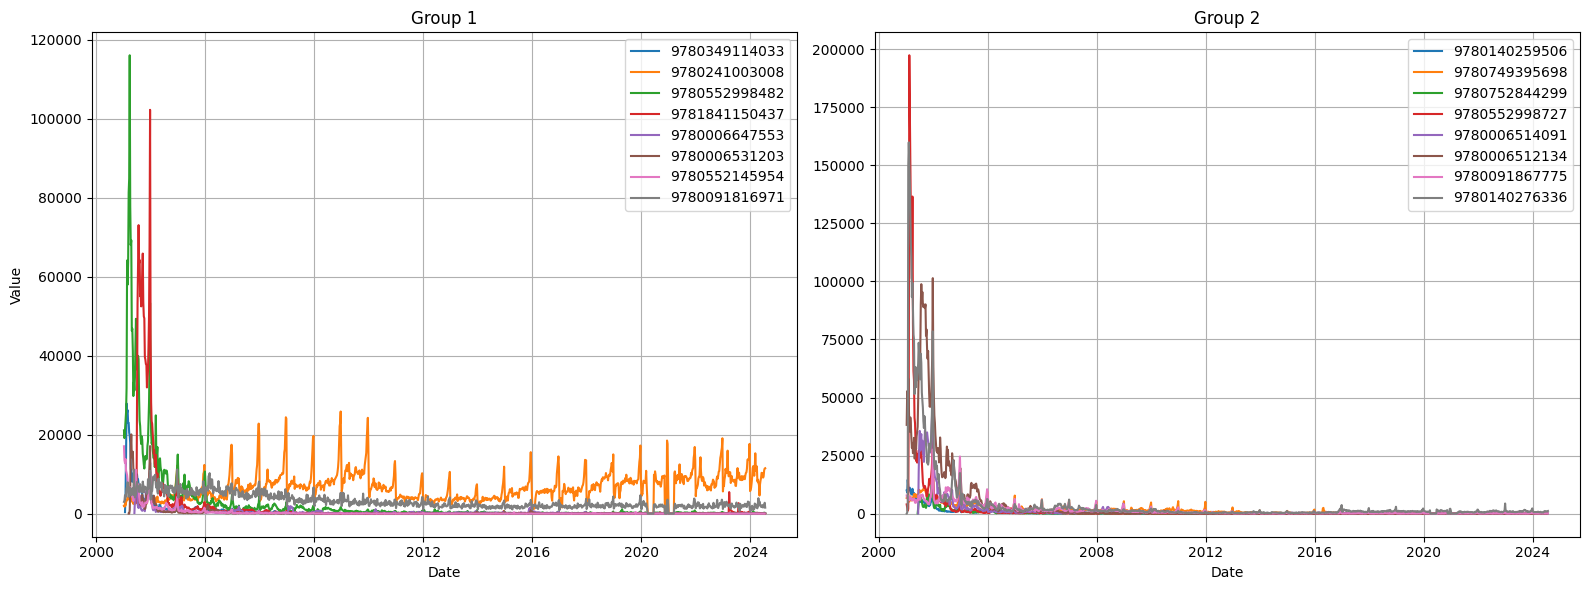

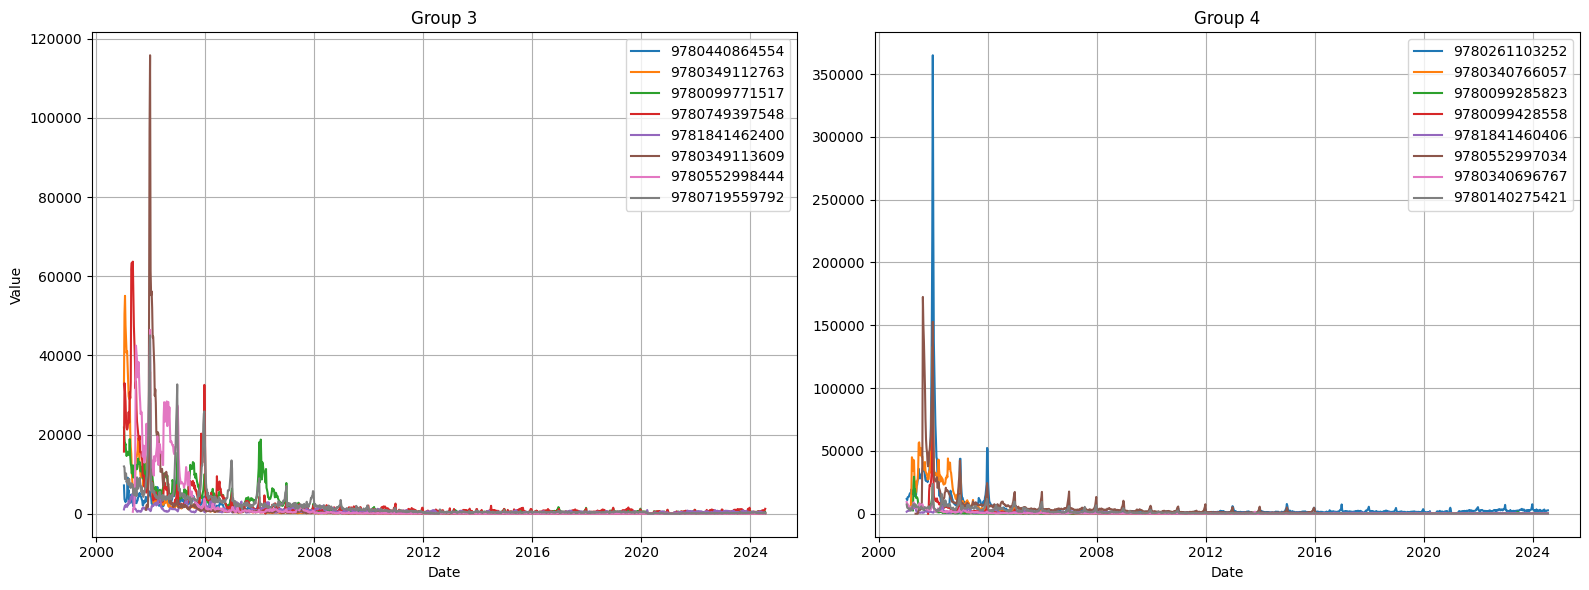

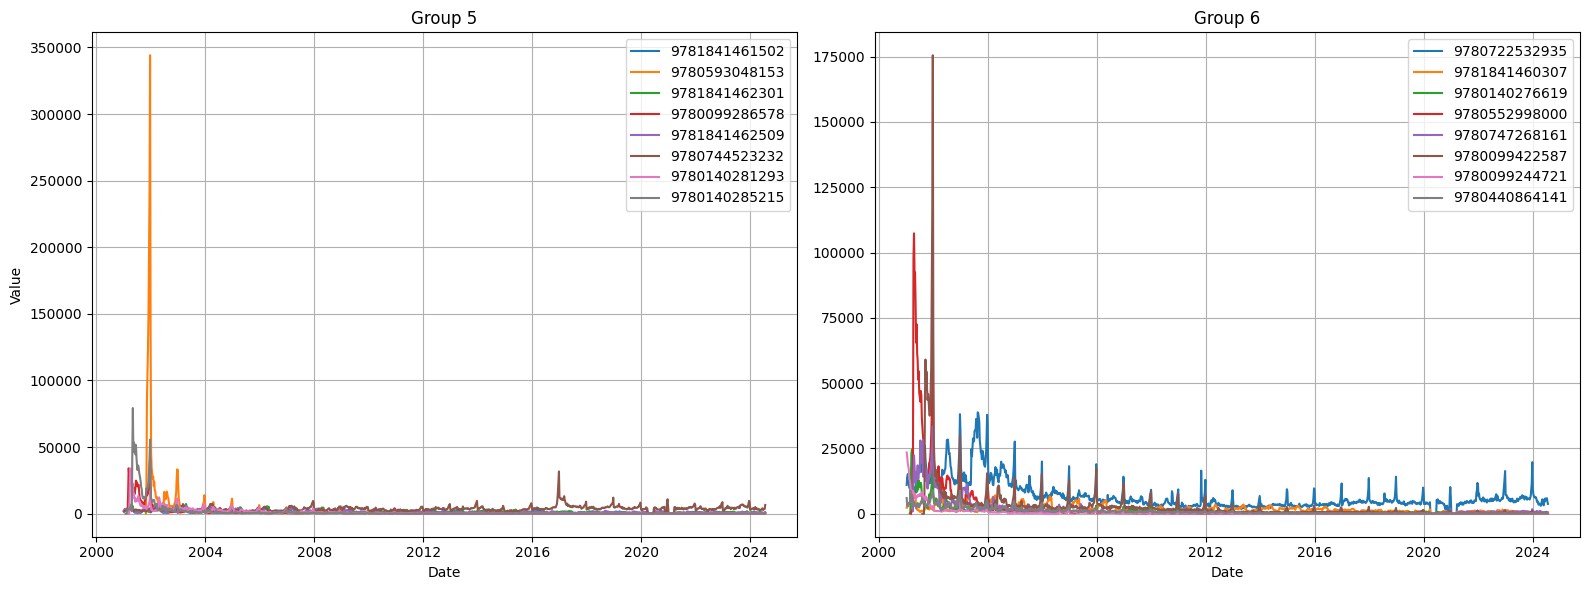

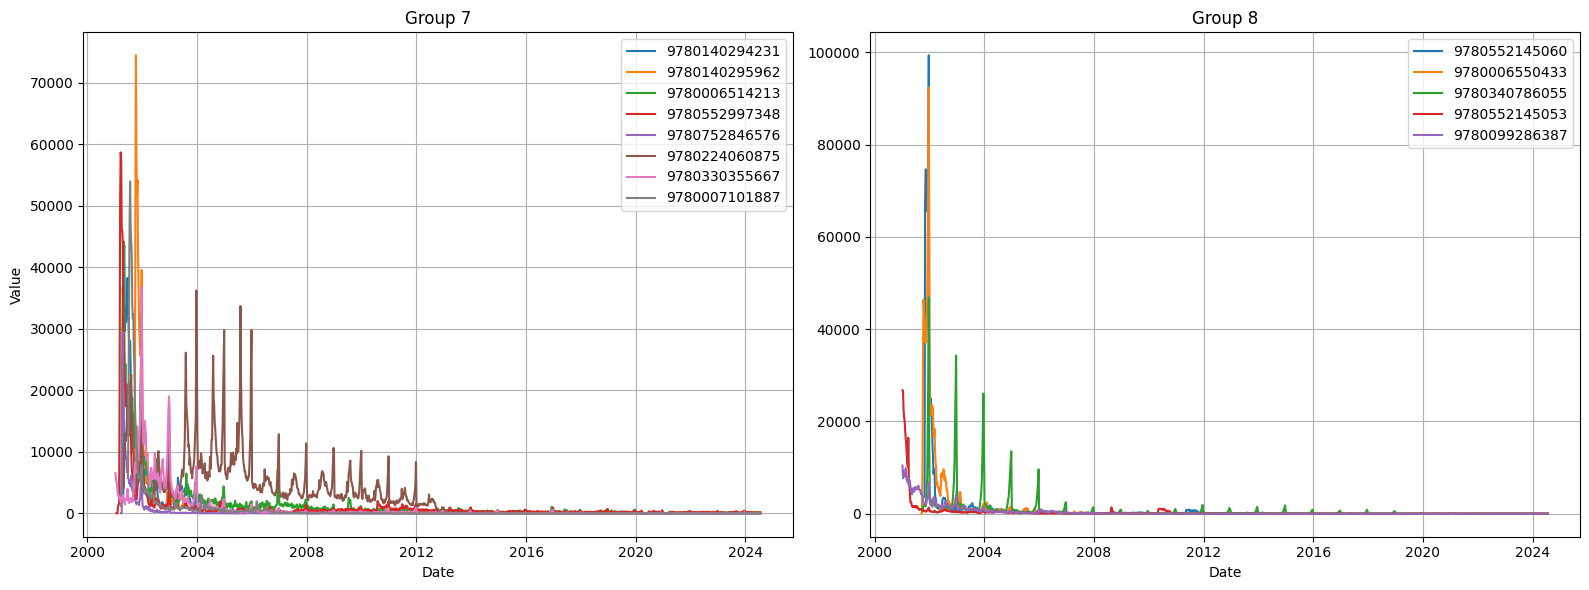

In [ ]:
# Helper function to split the ISBN list into chunks of 6–7
def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

chunk_size = 8
isbn_chunks = list(chunk_list(recent_ISBN, chunk_size))

# Plot 2 subplots per figure
for i in range(0, len(isbn_chunks), 2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    for j in range(2):  # up to 2 plots per row
        if i + j < len(isbn_chunks):
            ax = axes[j]
            for isbn in isbn_chunks[i + j]:
                sales_temp = uk_weekly_trend_allsheets[uk_weekly_trend_allsheets['ISBN'] == isbn]['Value']
                sales_temp = sales_temp.resample('W').sum().fillna(0)
                ax.plot(sales_temp, label=isbn)

            ax.set_title(f"Group {i + j + 1}")
            ax.set_xlabel("Date")
            if j == 0:
                ax.set_ylabel("Value")
            ax.legend()
            ax.grid(True)
        else:
            fig.delaxes(axes[j])  # remove empty subplot if odd number of groups

    plt.tight_layout()
    plt.show()


The ISBNs corresponding to the books A and B are extracted. For confidentiality reasons, the book titles cannot be explicitly shown in this work.

In [ ]:
title1 = ''
title2 = ''
ISBN_Book_A = IBSN_list_allsheets[IBSN_list_allsheets['Title']==title1]['ISBN'].astype(str).iloc[0]
ISBN_Book_B = IBSN_list_allsheets[IBSN_list_allsheets['Title']==title2]['ISBN'].astype(str).iloc[0]

Sales for the two aforementioned books are plotted below; as done previously, weeks with no sales data were filled with the value 0

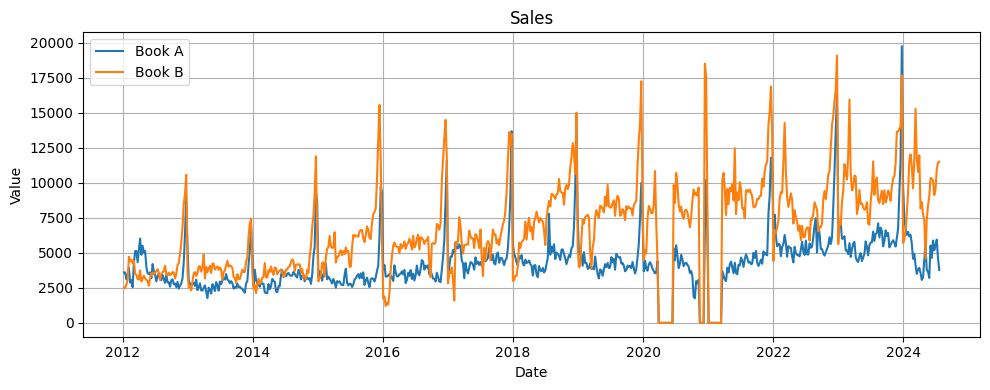

In [ ]:
ts_book1 = uk_weekly_trend_allsheets[(uk_weekly_trend_allsheets['ISBN'] == ISBN_Book_A) & (uk_weekly_trend_allsheets.index > pd.to_datetime('2012-01-01'))]['Value']
ts_book1 = ts_book1.resample('W').sum().fillna(0)
ts_book2 = uk_weekly_trend_allsheets[(uk_weekly_trend_allsheets['ISBN'] == ISBN_Book_B) & (uk_weekly_trend_allsheets.index > pd.to_datetime('2012-01-01'))]['Value']
ts_book2 = ts_book2.resample('W').sum().fillna(0)

plt.figure(figsize=(10, 4))
plt.plot(ts_book1)
plt.plot(ts_book2)
plt.title("Sales")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(['Book A','Book B'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Autocorrelation and Basic Decomposition

From now onwards, "Book A" will be referred to as "Book 1" and "Book B" will be referred to as "Book 2".

ACF and PACF for Book 1

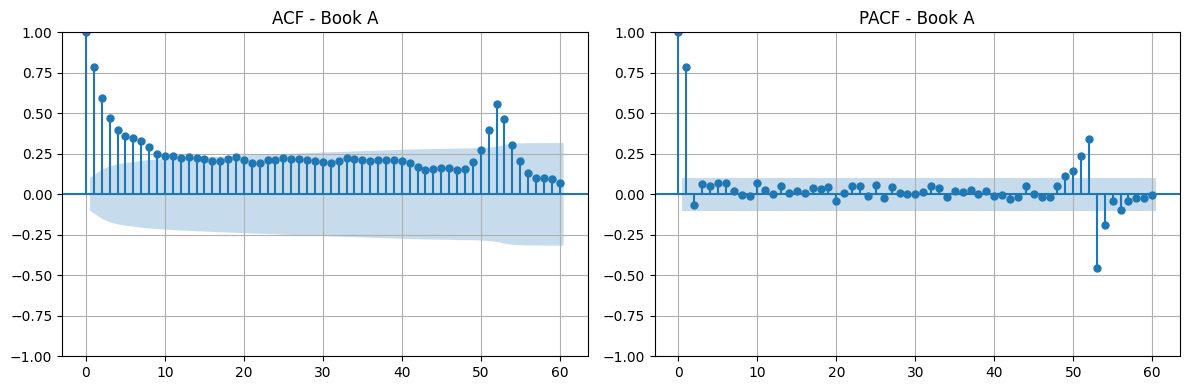

In [ ]:
plt.figure(figsize=(12, 4))

# ACF
plt.subplot(1, 2, 1)
sm.graphics.tsa.plot_acf(ts_book1, lags=60, ax=plt.gca(), alpha=0.01)
plt.title("ACF - Book A")
plt.grid(True)

# PACF
plt.subplot(1, 2, 2)
sm.graphics.tsa.plot_pacf(ts_book1, lags=60, ax=plt.gca(), alpha=0.01)
plt.title("PACF - Book A")
plt.grid(True)

plt.tight_layout()
plt.show()

ACF and PACF for Book 2

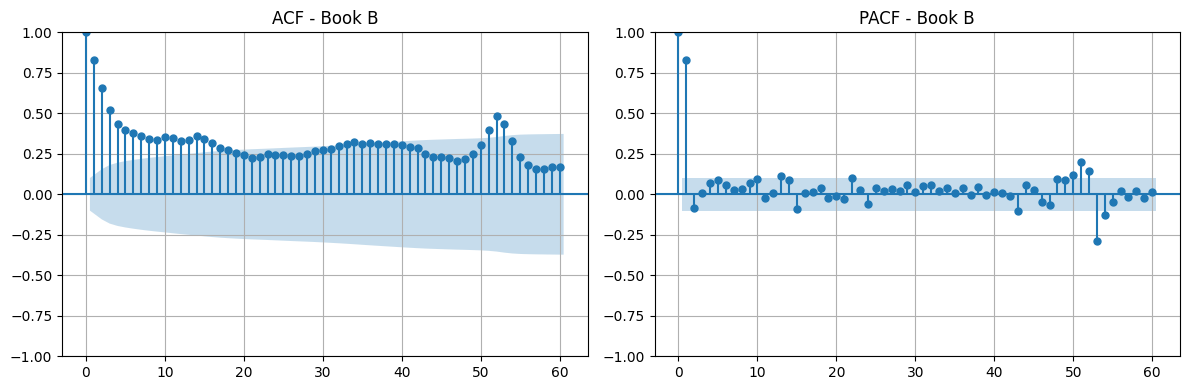

In [ ]:
plt.figure(figsize=(12, 4))

# ACF
plt.subplot(1, 2, 1)
sm.graphics.tsa.plot_acf(ts_book2, lags=60, ax=plt.gca(), alpha=0.01)
plt.title("ACF - Book B")
plt.grid(True)

# PACF
plt.subplot(1, 2, 2)
sm.graphics.tsa.plot_pacf(ts_book2, lags=60, ax=plt.gca(), alpha=0.01)
plt.title("PACF - Book B")
plt.grid(True)

plt.tight_layout()
plt.show()

As expected, the ACF and PACF for both books show a peak at and around the 52 weeks mark, suggesting a strong presence of yearly seasonality. Both time histories are then tested for stationarity with the ADF test.

In [ ]:
# Testing for stationarity - ADF Test
adf_result_weekly = adfuller(ts_book1)
print('P-value - ADF test for Book A:', adf_result_weekly[1])
if adf_result_weekly[1] > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')

P-value - ADF test for Book A: 5.719066144450924e-07
The data is stationary


In [ ]:
# Testing for stationarity - ADF Test
adf_result_weekly = adfuller(ts_book2)
print('P-value - ADF test for Book B:', adf_result_weekly[1])
if adf_result_weekly[1] > 0.05:
    print('The data is not stationary')
else:
    print('The data is stationary')

P-value - ADF test for Book B: 0.009674105120557913
The data is stationary


A data decomposition is then performed for both books to assess the impact of trend and seasonality using the *statsmodels* package. For every book, the following options are explored:

1.   Additive Decomposition
2.   Multiplicative Decomposition
3.   Additive Decomposition with *log* transformation



**Book 1:**

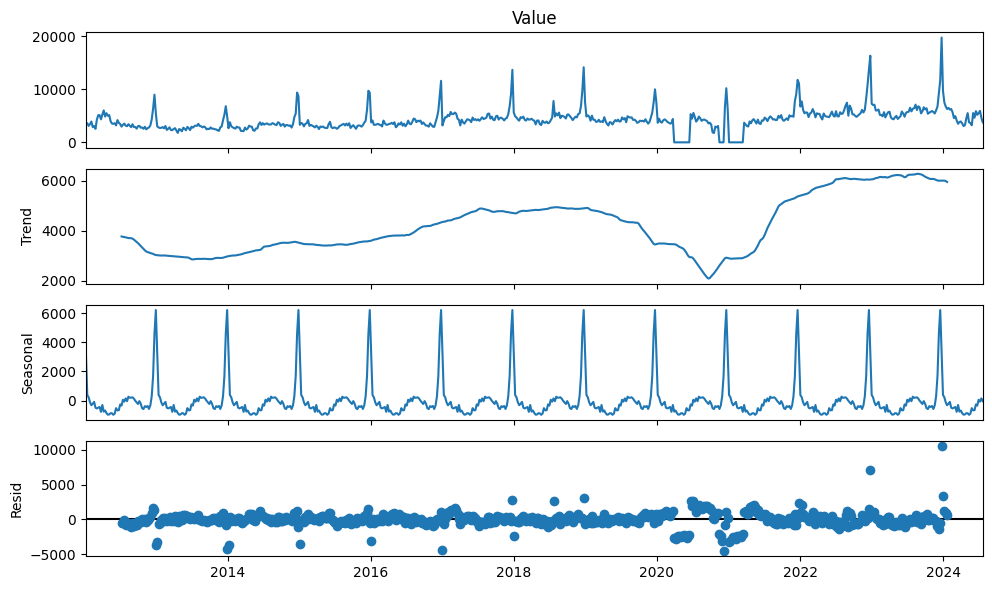

Lag 1: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 2: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 3: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 4: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 5: p-value = 0.0000 -> ❌ Significant autocorrelation


In [ ]:
# Perform data decomposition (additive).
plt.rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(ts_book1, model='additive')
fig = decomposition.plot()
plt.show()

# Assume 'residuals' is a pandas Series from seasonal decomposition
clean_residuals = decomposition.resid.dropna()

# Perform Ljung-Box test for lags up to 20
ljung_results = acorr_ljungbox(clean_residuals, lags=5, return_df=True)

# Print summary with interpretation
for lag, pval in enumerate(ljung_results['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

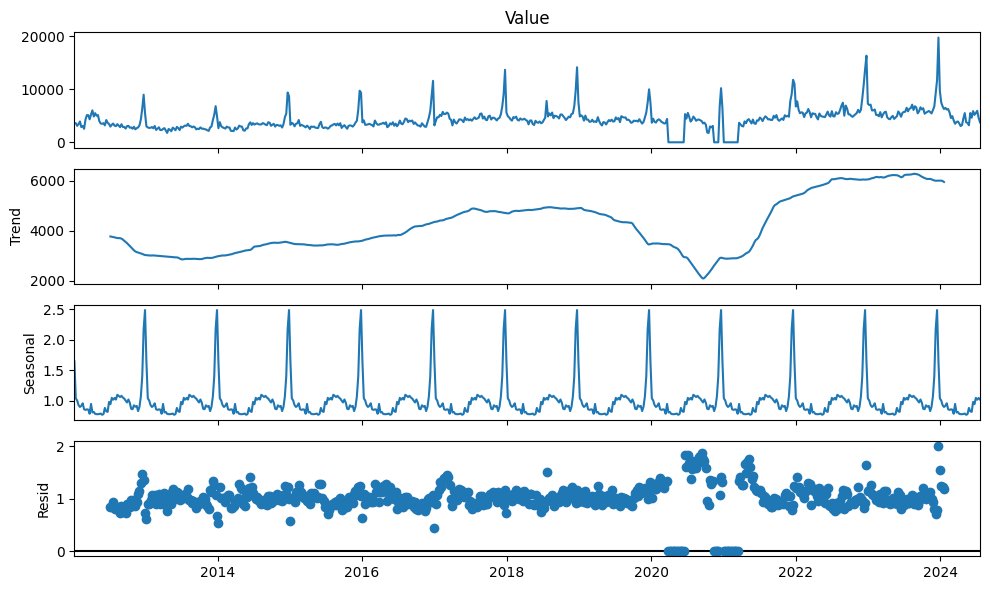

Lag 1: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 2: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 3: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 4: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 5: p-value = 0.0000 -> ❌ Significant autocorrelation


In [ ]:
# Perform data decomposition (additive).
plt.rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(ts_book1+1, model='multiplicative')
fig = decomposition.plot()
plt.show()

# Assume 'residuals' is a pandas Series from seasonal decomposition
clean_residuals = decomposition.resid.dropna()

# Perform Ljung-Box test for lags up to 20
ljung_results = acorr_ljungbox(clean_residuals, lags=5, return_df=True)

# Print summary with interpretation
for lag, pval in enumerate(ljung_results['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

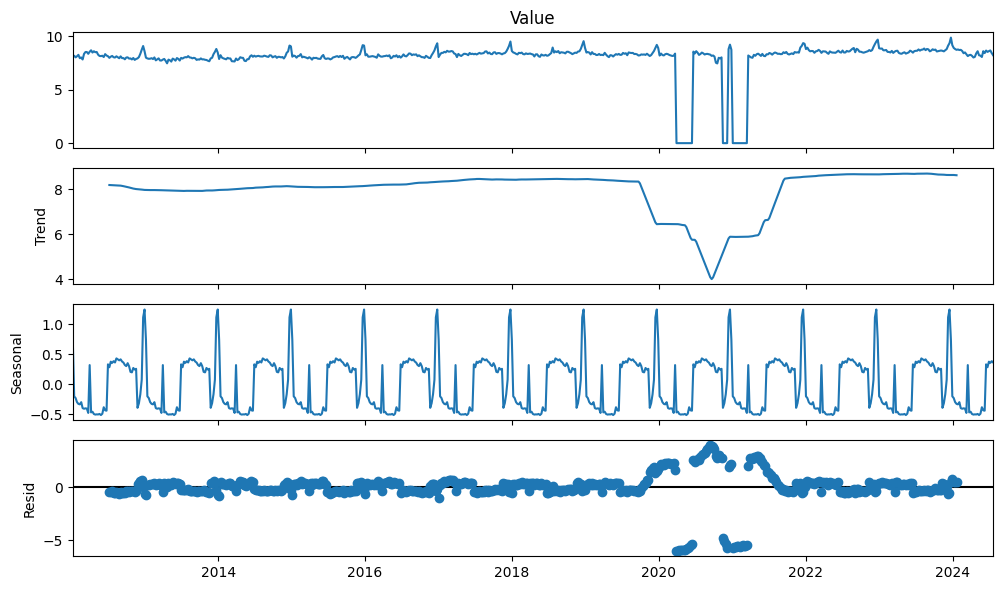

Lag 1: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 2: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 3: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 4: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 5: p-value = 0.0000 -> ❌ Significant autocorrelation


In [ ]:
# Perform data decomposition (additive).
plt.rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(np.log(ts_book1+1), model='additive')
fig = decomposition.plot()
plt.show()

# Assume 'residuals' is a pandas Series from seasonal decomposition
clean_residuals = decomposition.resid.dropna()

# Perform Ljung-Box test for lags up to 20
ljung_results = acorr_ljungbox(clean_residuals, lags=5, return_df=True)

# Print summary with interpretation
for lag, pval in enumerate(ljung_results['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

Concerning book 1 (Book A), it is the analyst's belief that an additive seasonality model works best, as the variance does **not** increase significantly with the trend. However, the Ljung-Box test performed on the residuals shows a significantly degree of autoocorrelation, highlighting the need for more sophisticated models.

**Book 2:**

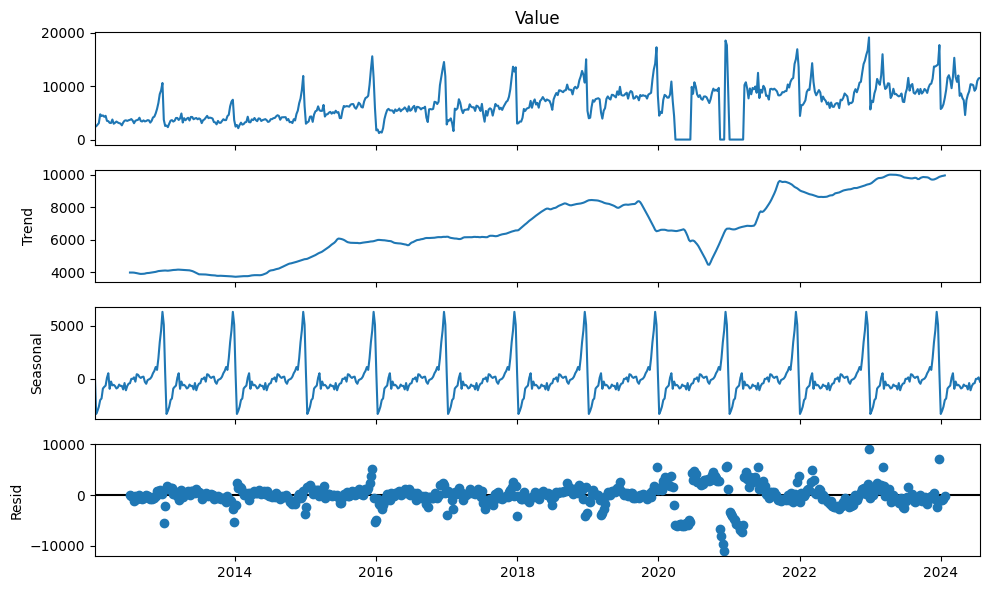

Lag 1: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 2: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 3: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 4: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 5: p-value = 0.0000 -> ❌ Significant autocorrelation


In [ ]:
# Perform data decomposition (additive).
plt.rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(ts_book2, model='additive')
fig = decomposition.plot()
plt.show()

# Assume 'residuals' is a pandas Series from seasonal decomposition
clean_residuals = decomposition.resid.dropna()

# Perform Ljung-Box test for lags up to 20
ljung_results = acorr_ljungbox(clean_residuals, lags=5, return_df=True)

# Print summary with interpretation
for lag, pval in enumerate(ljung_results['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

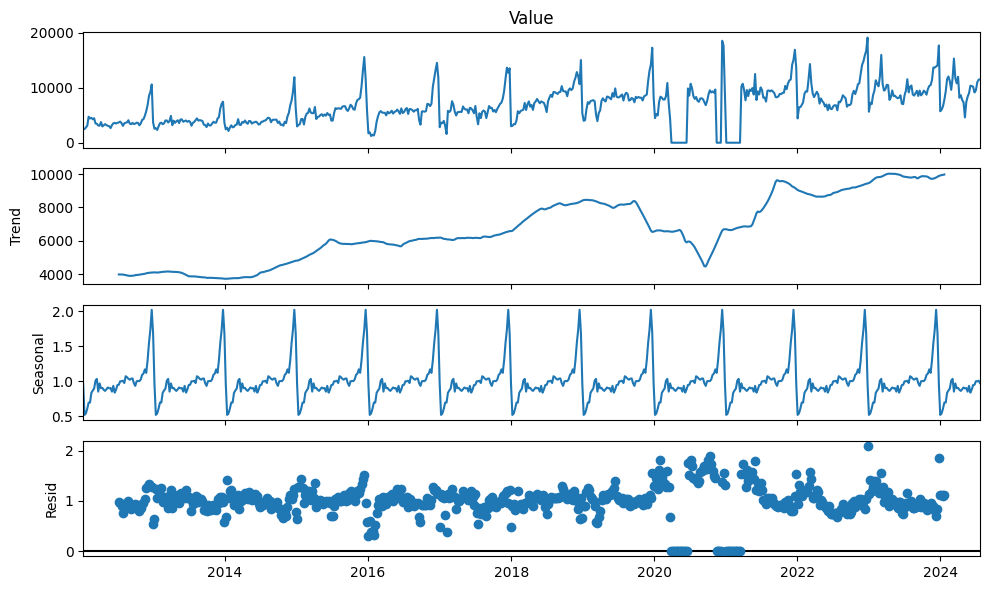

Lag 1: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 2: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 3: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 4: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 5: p-value = 0.0000 -> ❌ Significant autocorrelation


In [ ]:
# Perform data decomposition (multiplicative).
plt.rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(ts_book2+1, model='multiplicative')
fig = decomposition.plot()
plt.show()

# Assume 'residuals' is a pandas Series from seasonal decomposition
clean_residuals = decomposition.resid.dropna()

# Perform Ljung-Box test for lags up to 20
ljung_results = acorr_ljungbox(clean_residuals, lags=5, return_df=True)

# Print summary with interpretation
for lag, pval in enumerate(ljung_results['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

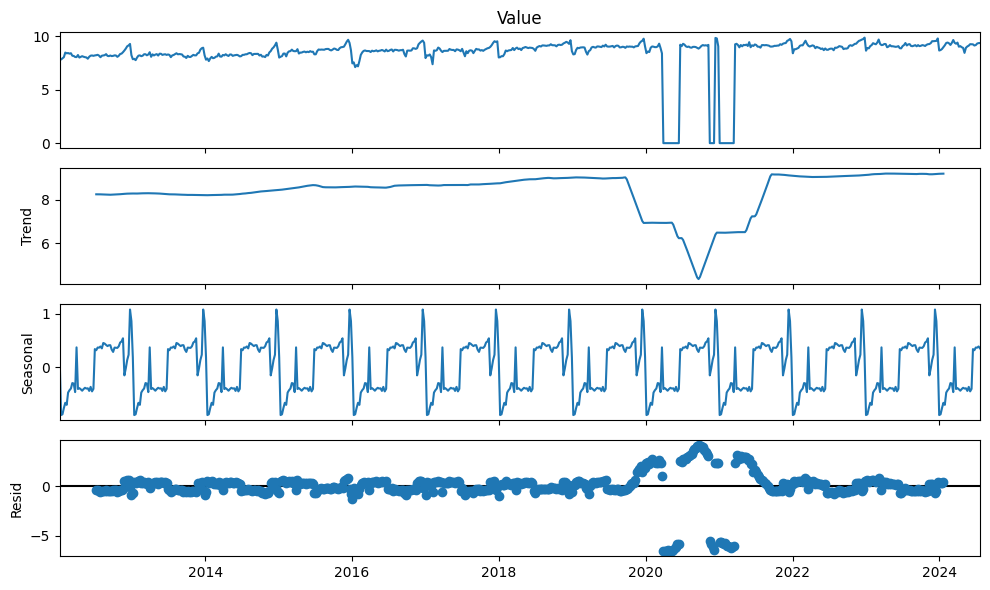

Lag 1: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 2: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 3: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 4: p-value = 0.0000 -> ❌ Significant autocorrelation
Lag 5: p-value = 0.0000 -> ❌ Significant autocorrelation


In [ ]:
# Perform data decomposition (additive on log).
plt.rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(np.log(ts_book2+1), model='additive')
fig = decomposition.plot()
plt.show()

# Assume 'residuals' is a pandas Series from seasonal decomposition
clean_residuals = decomposition.resid.dropna()

# Perform Ljung-Box test for lags up to 20
ljung_results = acorr_ljungbox(clean_residuals, lags=5, return_df=True)

# Print summary with interpretation
for lag, pval in enumerate(ljung_results['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

In this case instead, the variance shows a larger dependance on the trend, therefore a multiplicative model would be more appropriate. However, we are aware of the fact that SARIMA can not handle multiplicative seasonality, and the log transformation applied on the third plot shows a very distorted seasonal pattern and very unstable residuals around the time with no sales. Therefore, it was decided to stick with the additive decomposition regardless of these considerations.

### Auto-Arima Modelling

From here onwards, the two time series are modelled using Auto-Arima. The forecast horizon is 32 weeks and the training data was set to the previous 8 cycles, corresponding to 8 years. This was found to be the best compromise between accuracy and limitation on the computational resources

In [ ]:
ncycles = 8

n_forecast_periods = 32
lookback = 52*ncycles

ts_book1_train = ts_book1.iloc[:-n_forecast_periods]
ts_book1_train_subset = ts_book1.iloc[-n_forecast_periods-lookback:-n_forecast_periods]
#ts_book1_train_subset = ts_book1_train.copy()
ts_book1_test = ts_book1.iloc[-n_forecast_periods:]

ts_book2_train = ts_book1.iloc[:-n_forecast_periods]
ts_book2_train_subset = ts_book2.iloc[-n_forecast_periods-lookback:-n_forecast_periods]
#ts_book2_train_subset = ts_book2_train.copy()
ts_book2_test = ts_book2.iloc[-n_forecast_periods:]

Auto ARIMA was used on the time series for both books. The chosen hyperparameters intervals and settings mirror a balance between accuracy and computational resources. In more detail:

- **Differencing**: The model allows `auto_arima` to determine the appropriate level of non-seasonal differencing (`d`) up to a maximum of 2.

- **Seasonality**: Seasonal modeling is enabled with a period of 52, reflecting yearly patterns in weekly observations. Seasonal differencing (`D`) is fixed at 1 to capture annual seasonality in the weekly data.

- **Model Selection**: The best model is selected based on the Akaike Information Criterion (AIC), which balances model fit and complexity.

- **Scoring**: Mean Squared Error (MSE) is used to evaluate model accuracy during the search process.


**Disclaimer:**

The cells below are commented as they were only run once. Models were then saved to .pkl files and uploaded when necessary.

In [ ]:
"""
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

# Fit Auto ARIMA model to ts_train with specified bounds
autoarima_model = auto_arima(
    y=ts_book1_train_subset,
    d=None,
    start_d=0, max_d=2,
    D=1,                     # seasonal differencing fixed
    start_p=0, max_p=2,      # AR terms
    start_q=0, max_q=2,      # MA terms
    start_P=0, max_P=1,      # Seasonal AR
    start_Q=0, max_Q=1,      # Seasonal MA
    max_order=None,          # let p+q+P+Q be unconstrained\
    m=52,                    # seasonal period = 52 weeks
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss', seasonal_test='ocsb',
    stepwise=False, n_jobs=1, start_params=None, trend=None,
    method='lbfgs', maxiter=20, offset_test_args=None, seasonal_test_args=None,
    suppress_warnings=True, error_action='trace',
    trace=False, random=False, random_state=None, n_fits=10,
    return_valid_fits=False, out_of_sample_size=0, scoring='mse',
    scoring_args=None, with_intercept='auto', sarimax_kwargs=None)
"""

'\nwarnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")\n\n# Fit Auto ARIMA model to ts_train with specified bounds\nautoarima_model = auto_arima(\n    y=ts_book1_train_subset,\n    d=None,\n    start_d=0, max_d=2,\n    D=1,                     # seasonal differencing fixed\n    start_p=0, max_p=2,      # AR terms\n    start_q=0, max_q=2,      # MA terms\n    start_P=0, max_P=1,      # Seasonal AR\n    start_Q=0, max_Q=1,      # Seasonal MA\n    max_order=None,          # let p+q+P+Q be unconstrained    m=52,                    # seasonal period = 52 weeks\n    seasonal=True,\n    stationary=False,\n    information_criterion=\'aic\',\n    alpha=0.05,\n    test=\'kpss\', seasonal_test=\'ocsb\',\n    stepwise=False, n_jobs=1, start_params=None, trend=None,\n    method=\'lbfgs\', maxiter=20, offset_test_args=None, seasonal_test_args=None,\n    suppress_warnings=True, error_action=\'trace\',\n    trace=False, random=False, random_state=None, n_fits=10,\

In [ ]:
"""
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

# Fit Auto ARIMA model to ts_train with specified bounds
autoarima_model_2 = auto_arima(
    y=ts_book2_train_subset,
    d=None,
    start_d=0, max_d=2,
    D=1,                     # seasonal differencing fixed
    start_p=0, max_p=2,      # AR terms
    start_q=0, max_q=2,      # MA terms
    start_P=0, max_P=1,      # Seasonal AR
    start_Q=0, max_Q=1,      # Seasonal MA
    max_order=None,          # let p+q+P+Q be unconstrained\
    m=52,                    # seasonal period = 52 weeks
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss', seasonal_test='ocsb',
    stepwise=False, n_jobs=1, start_params=None, trend=None,
    method='lbfgs', maxiter=20, offset_test_args=None, seasonal_test_args=None,
    suppress_warnings=True, error_action='trace',
    trace=False, random=False, random_state=None, n_fits=10,
    return_valid_fits=False, out_of_sample_size=0, scoring='mse',
    scoring_args=None, with_intercept='auto', sarimax_kwargs=None)

"""

'\nwarnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")\n\n# Fit Auto ARIMA model to ts_train with specified bounds\nautoarima_model_2 = auto_arima(\n    y=ts_book2_train_subset,\n    d=None,\n    start_d=0, max_d=2,\n    D=1,                     # seasonal differencing fixed\n    start_p=0, max_p=2,      # AR terms\n    start_q=0, max_q=2,      # MA terms\n    start_P=0, max_P=1,      # Seasonal AR\n    start_Q=0, max_Q=1,      # Seasonal MA\n    max_order=None,          # let p+q+P+Q be unconstrained    m=52,                    # seasonal period = 52 weeks\n    seasonal=True,\n    stationary=False,\n    information_criterion=\'aic\',\n    alpha=0.05,\n    test=\'kpss\', seasonal_test=\'ocsb\',\n    stepwise=False, n_jobs=1, start_params=None, trend=None,\n    method=\'lbfgs\', maxiter=20, offset_test_args=None, seasonal_test_args=None,\n    suppress_warnings=True, error_action=\'trace\',\n    trace=False, random=False, random_state=None, n_fits=10

The auto-arima models are saved onto .pkl files

In [ ]:
"""
import os
os.makedirs('/content/drive/MyDrive/models', exist_ok=True)

import pickle

model_path = '/content/drive/MyDrive/models/Book_1_ARIMA_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(autoarima_model, f)

model_path = '/content/drive/MyDrive/models/Book_2_ARIMA_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(autoarima_model_2, f)

"""

"\nimport os\nos.makedirs('/content/drive/MyDrive/models', exist_ok=True)\n\nimport pickle\n\nmodel_path = '/content/drive/MyDrive/models/Book_1_ARIMA_model.pkl'\n\nwith open(model_path, 'wb') as f:\n    pickle.dump(autoarima_model, f)\n\nmodel_path = '/content/drive/MyDrive/models/Book_2_ARIMA_model.pkl'\n\nwith open(model_path, 'wb') as f:\n    pickle.dump(autoarima_model_2, f)\n\n"

The auto-ARIMA models are re-uploaded from the previously saved .pkl files

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#reload models
import pickle

model_path = '/content/drive/MyDrive/Colab Notebooks/Saved_Models/'

with open(model_path+'Book_1_ARIMA_model.pkl', 'rb') as f:
    autoarima_model = pickle.load(f)
with open(model_path+'Book_2_ARIMA_model.pkl', 'rb') as f:
    autoarima_model_2 = pickle.load(f)

Mounted at /content/drive


The summary of the auto arima model for "Book A" is shown in the cells below

In [ ]:
print('Book A:')
print(autoarima_model.summary())

Book A:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  416
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -3021.931
Date:                              Sun, 24 Aug 2025   AIC                           6051.861
Time:                                      11:20:57   BIC                           6067.439
Sample:                                  12-27-2015   HQIC                          6058.053
                                       - 12-10-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3431      0.034    -10.192      0.000      -0.409      -0.277
ma.L2      

- **Model Order**: SARIMAX(0, 1, 2)x(0, 1, [1], 52)
  
- **Parameter Significance**:
  - All MA coefficients (L1, L2, and seasonal L52) are **statistically significant** (P < 0.01).
  - Indicates meaningful short-term and annual dependencies.

- **Residual Diagnostics**:
  - **Ljung-Box Test** (L1): p = 0.87 → No significant autocorrelation remains at lag 1.
  - **Jarque-Bera Test**: p = 0.00 → Residuals are **not normally distributed**.
  - **Heteroskedasticity Test (H)**: p = 0.00 → Residual variance is not constant over time (heteroskedastic).

- **Variance Estimate**:
  - `sigma2`: The estimated variance of the residuals is quite high (~962,000), which may reflect scale or outliers.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


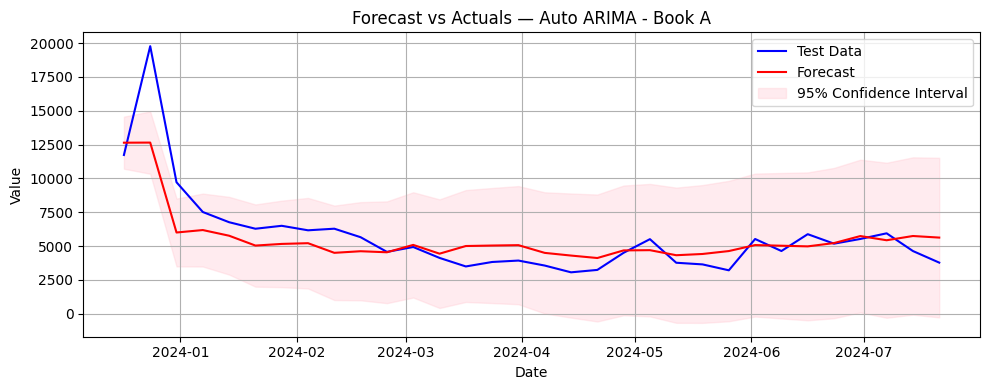

The MAPE index is 20.07 %


In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr, conf_int_arr = autoarima_model.predict(n_periods=n_forecast_periods, return_conf_int=True)

# Step 2: Ensure index alignment
forecast_index = ts_book1_test.index

# Step 3: Create numeric Series/DataFrames with clean data
forecast = pd.Series(forecast_arr, index=forecast_index)
conf_int = pd.DataFrame(conf_int_arr, columns=["Lower", "Upper"], index=forecast_index)

# Step 4: Force float types + drop NaNs (optional safety net)
forecast = forecast.astype(float)
conf_int = conf_int.astype(float)

forecast = forecast.dropna()
conf_int = conf_int.dropna()

# Step 5: Plot
plt.figure(figsize=(10, 4))
#plt.plot(ts_book1_train_subset, label="Training Data", color="black")
plt.plot(ts_book1_test, label="Test Data", color="blue")
plt.plot(forecast, label="Forecast", color="red")

# Confidence interval plotting (ensures numeric, index-aligned input)
plt.fill_between(
    conf_int.index,
    conf_int["Lower"].values,
    conf_int["Upper"].values,
    color="pink",
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.title("Forecast vs Actuals — Auto ARIMA - Book A")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(ts_book1_test, forecast)
mape = mean_absolute_percentage_error(ts_book1_test, forecast)
print("The MAPE index is", round(mape*100,2), "%")

In [ ]:
summary_book_1 = pd.DataFrame(
    data={'ARIMA': [mae, round(mape*100,2)]},
    index=['MAE', 'MAPE [%]']
)

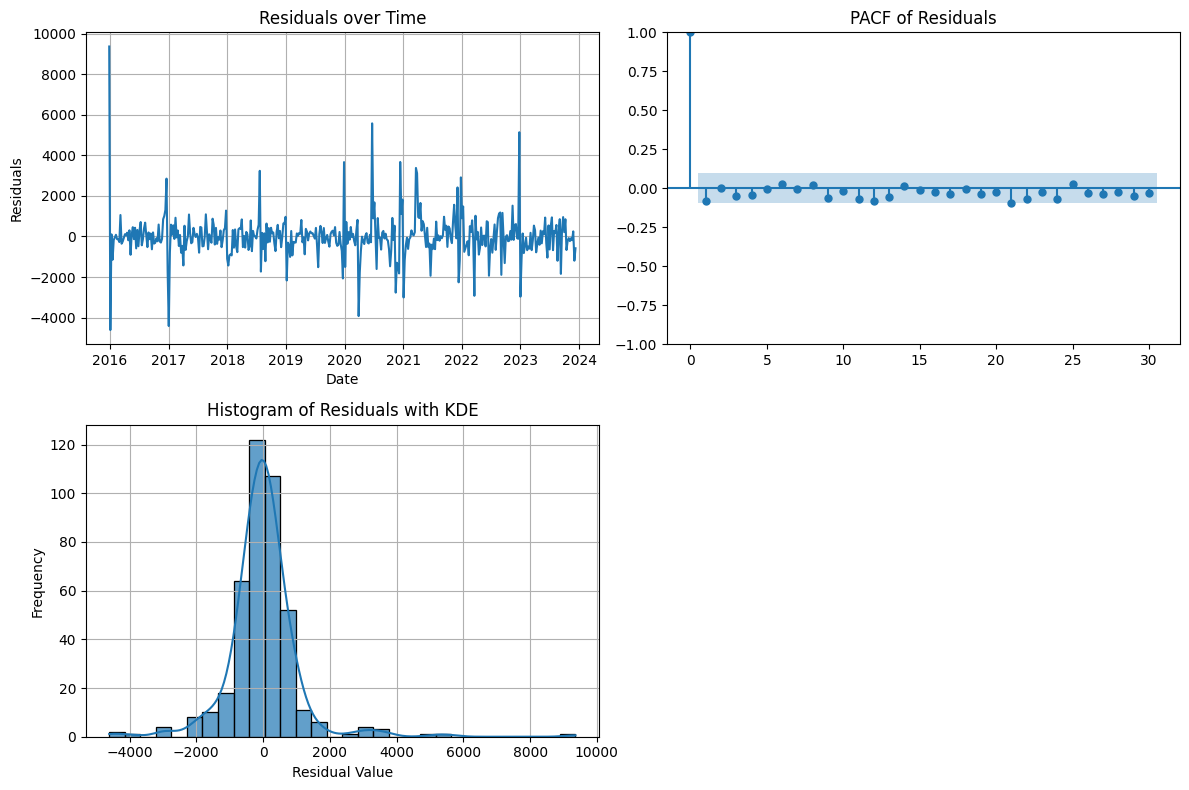

Lag 1: p-value = 0.0981 -> ✅ No significant autocorrelation
Lag 2: p-value = 0.2484 -> ✅ No significant autocorrelation
Lag 3: p-value = 0.2803 -> ✅ No significant autocorrelation
Lag 4: p-value = 0.3525 -> ✅ No significant autocorrelation
Lag 5: p-value = 0.4910 -> ✅ No significant autocorrelation
Lag 6: p-value = 0.5683 -> ✅ No significant autocorrelation
Lag 7: p-value = 0.6824 -> ✅ No significant autocorrelation
Lag 8: p-value = 0.7526 -> ✅ No significant autocorrelation
Lag 9: p-value = 0.6310 -> ✅ No significant autocorrelation
Lag 10: p-value = 0.7151 -> ✅ No significant autocorrelation


In [ ]:
import seaborn as sns

# Step 1: Get residuals
residuals_ts1 = pd.Series(autoarima_model.resid(), index=ts_book1_train_subset.index)

# Step 2: Plot residuals (time series), PACF, and histogram with KDE in 2x2 layout
plt.figure(figsize=(12, 8))

# Residuals over time
plt.subplot(2, 2, 1)
plt.plot(residuals_ts1)
plt.title("Residuals over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)

# PACF plot
plt.subplot(2, 2, 2)
sm.graphics.tsa.plot_pacf(residuals_ts1.dropna(), lags=30, ax=plt.gca())
plt.title("PACF of Residuals")

# Histogram with KDE
plt.subplot(2, 2, 3)
sns.histplot(residuals_ts1.dropna(), bins=30, kde=True, edgecolor='k', alpha=0.7)
plt.title("Histogram of Residuals with KDE")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 3: Perform Ljung-Box test for lags up to 10
lb_test = acorr_ljungbox(residuals_ts1.dropna(), lags=10, return_df=True)

# Step 4: Print test results with interpretation
for lag, pval in enumerate(lb_test['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

A visual inspection of the prediction against the test dataset suggests a good prediction power of this model, which is confirmed by the MAPE value of about 20%. A quick analysis of the residuals using the Ljung-box test shows no autocorrelation left, which is confirmed by the PACF.

Limitations of this model arise from the heteroskedasticity (non-constant variance) and non-normality of the residuals.

All steps are repeated for "Book B"

In [ ]:
print(autoarima_model_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  416
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 52)   Log Likelihood               -3298.814
Date:                            Sun, 24 Aug 2025   AIC                           6605.629
Time:                                    11:20:59   BIC                           6621.217
Sample:                                12-27-2015   HQIC                          6611.825
                                     - 12-10-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    164.6737    112.061      1.470      0.142     -54.962     384.309
ar.L1          0.7836      0.023   

- **Model Order**: SARIMAX(1, 0, 0) × (1, 1, 0, 52)
  - The model uses no non-seasonal differencing but includes first-order seasonal differencing.

- **Parameter Significance**:
  - The **intercept** is not statistically significant (p = 0.142), suggesting it may not contribute meaningfully.
  - Both AR terms (non-seasonal and seasonal) are **highly significant** (p < 0.001), confirming strong autoregressive effects.

- **Residual Diagnostics**:
  - **Ljung-Box Test** (L1): p = 0.76 → No evidence of autocorrelation at lag 1.
  - **Jarque-Bera Test**: p = 0.00 → Residuals are **not normally distributed**.
  - **Heteroskedasticity Test (H)**: p = 0.00 → Residuals exhibit **heteroskedasticity** (non-constant variance).

- **Variance Estimate**:
  - `sigma2`: Estimated residual variance is ~4.24 million, indicating higher noise relative to the previous model.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


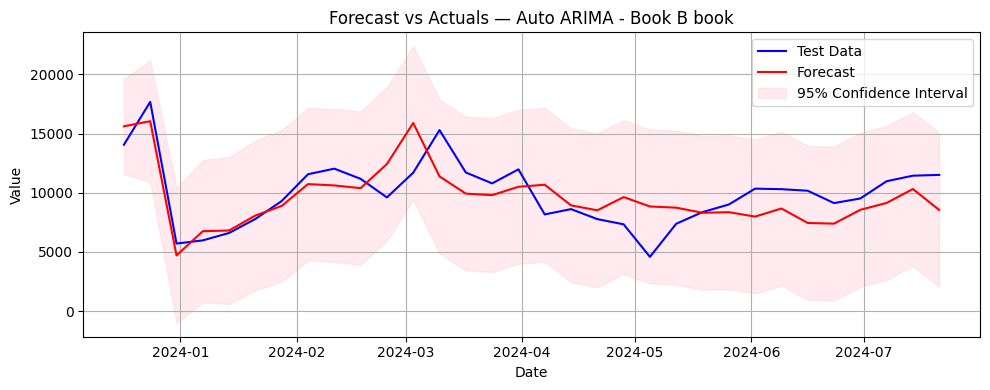

The MAPE index is 17.39 %


In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr, conf_int_arr = autoarima_model_2.predict(n_periods=n_forecast_periods, return_conf_int=True)

# Step 2: Ensure index alignment
forecast_index = ts_book2_test.index

# Step 3: Create numeric Series/DataFrames with clean data
forecast = pd.Series(forecast_arr, index=forecast_index)
conf_int = pd.DataFrame(conf_int_arr, columns=["Lower", "Upper"], index=forecast_index)

# Step 4: Force float types + drop NaNs (optional safety net)
forecast = forecast.astype(float)
conf_int = conf_int.astype(float)

forecast = forecast.dropna()
conf_int = conf_int.dropna()

# Step 5: Plot
plt.figure(figsize=(10, 4))
#plt.plot(ts_book2_train_subset, label="Training Data", color="black")
plt.plot(ts_book2_test, label="Test Data", color="blue")
plt.plot(forecast, label="Forecast", color="red")

# Confidence interval plotting (ensures numeric, index-aligned input)
plt.fill_between(
    conf_int.index,
    conf_int["Lower"].values,
    conf_int["Upper"].values,
    color="pink",
    alpha=0.3,
    label="95% Confidence Interval"
)

plt.title("Forecast vs Actuals — Auto ARIMA - Book B book")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(ts_book2_test, forecast)
mape = mean_absolute_percentage_error(ts_book2_test, forecast)
print("The MAPE index is", round(mape*100,2), "%")

In [ ]:
summary_book_2 = pd.DataFrame(
    data={'ARIMA': [mae, round(mape*100,2)]},
    index=['MAE', 'MAPE [%]']
)

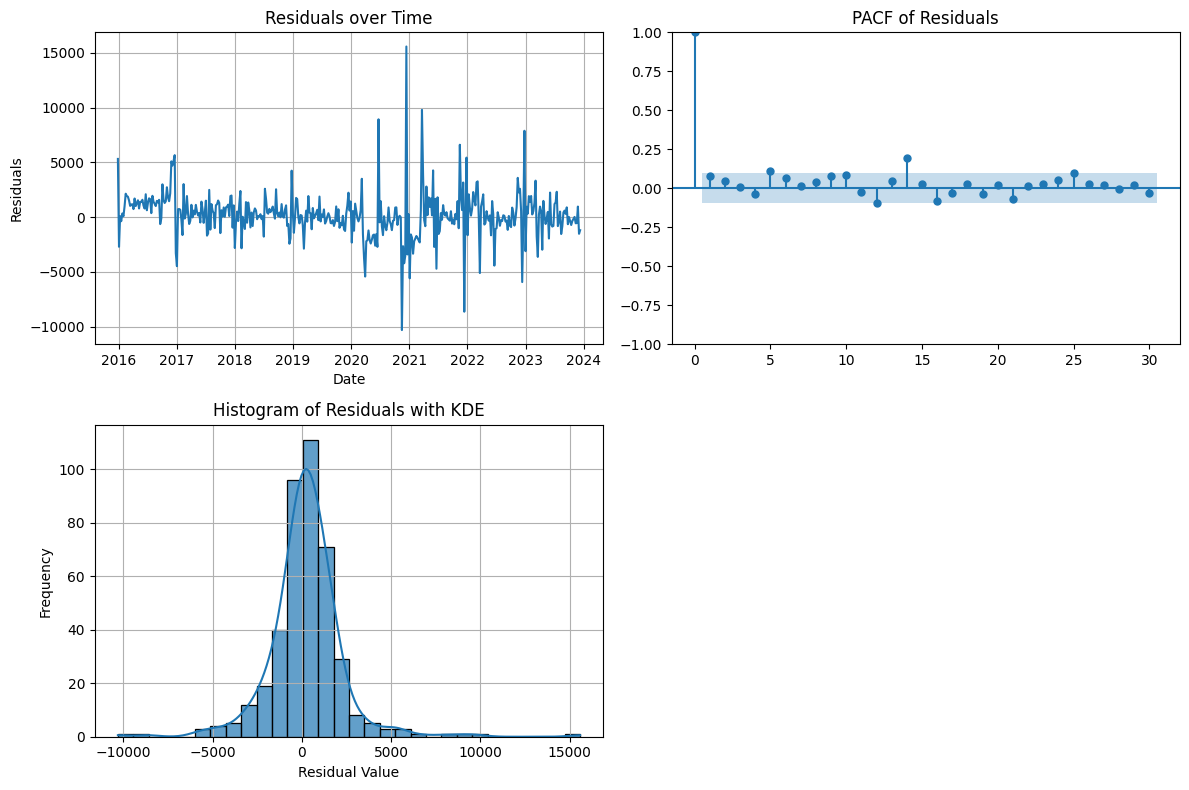

Lag 1: p-value = 0.1160 -> ✅ No significant autocorrelation
Lag 2: p-value = 0.1620 -> ✅ No significant autocorrelation
Lag 3: p-value = 0.2858 -> ✅ No significant autocorrelation
Lag 4: p-value = 0.3714 -> ✅ No significant autocorrelation
Lag 5: p-value = 0.1033 -> ✅ No significant autocorrelation
Lag 6: p-value = 0.0661 -> ✅ No significant autocorrelation
Lag 7: p-value = 0.0903 -> ✅ No significant autocorrelation
Lag 8: p-value = 0.0941 -> ✅ No significant autocorrelation
Lag 9: p-value = 0.0634 -> ✅ No significant autocorrelation
Lag 10: p-value = 0.0234 -> ❌ Significant autocorrelation


In [ ]:
import seaborn as sns

# Step 1: Get residuals
residuals_ts2 = pd.Series(autoarima_model_2.resid(), index=ts_book2_train_subset.index)

# Step 2: Plot residuals (time series), PACF, and histogram with KDE in 2x2 layout
plt.figure(figsize=(12, 8))

# Residuals over time
plt.subplot(2, 2, 1)
plt.plot(residuals_ts2)
plt.title("Residuals over Time")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)

# PACF plot
plt.subplot(2, 2, 2)
sm.graphics.tsa.plot_pacf(residuals_ts2.dropna(), lags=30, ax=plt.gca())
plt.title("PACF of Residuals")

# Histogram with KDE
plt.subplot(2, 2, 3)
sns.histplot(residuals_ts2.dropna(), bins=30, kde=True, edgecolor='k', alpha=0.7)
plt.title("Histogram of Residuals with KDE")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 3: Perform Ljung-Box test for lags up to 10
lb_test = acorr_ljungbox(residuals_ts2.dropna(), lags=10, return_df=True)

# Step 4: Print test results with interpretation
for lag, pval in enumerate(lb_test['lb_pvalue'], start=1):
    if pval < 0.05:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ❌ Significant autocorrelation")
    else:
        print(f"Lag {lag}: p-value = {pval:.4f} -> ✅ No significant autocorrelation")

In [ ]:
"""
joblib.dump(autoarima_model, 'Book_1_ARIMA_model.pkl')
joblib.dump(autoarima_model_2, 'Book_2_ARIMA_model.pkl')
"""

"\njoblib.dump(autoarima_model, 'Book_1_ARIMA_model.pkl')\njoblib.dump(autoarima_model_2, 'Book_2_ARIMA_model.pkl')\n"

Even for this book, the model shows very good predictive power, which is confirmed by a MAPE of 17.39%. However, residuals are heteroskedatic and not normally distributed, suggesting that further investigations are needed.

### XGBoost Modelling

The function below converts the data into the input sequences - output sequences pairs required to run XGBoost and LSTM. A test is also performed on dummy data.

In [ ]:
def create_input_output_sequences_xgb(lookback, forecast, sequence_data):
  input_sequences = []
  output_sequences = []

  for i in range(lookback, len(sequence_data) - forecast + 1):

      input_sequences.append(sequence_data[i - lookback: i])
      output_sequences.append(sequence_data[i: i + forecast])

  return input_sequences, output_sequences

In [ ]:
test = ts_book1_train.iloc[:10].to_numpy()
look_back = 4
forecast = 3
input_sequences, output_sequences = create_input_output_sequences_xgb(look_back, forecast, test)
print(input_sequences)
print(output_sequences)

[array([3601.76, 3610.12, 3105.62, 3431.29]), array([3610.12, 3105.62, 3431.29, 3929.22]), array([3105.62, 3431.29, 3929.22, 2874.98]), array([3431.29, 3929.22, 2874.98, 3073.17])]
[array([3929.22, 2874.98, 3073.17]), array([2874.98, 3073.17, 2544.06]), array([3073.17, 2544.06, 4283.9 ]), array([2544.06, 4283.9 , 5124.93])]


Due to limits in the computational resources, the train data subset was reduced to the last 6 years (after removing the last 32 weeks to create the test set)

In [ ]:
ts_book1_train_subset_XGB = ts_book1_train_subset.iloc[-52*6:]
ts_book1_train_subset_XGB.index = pd.PeriodIndex(ts_book1_train_subset_XGB.index, freq="W")
#ts_book1_test_XGB.index = pd.PeriodIndex(ts_book1_test.index, freq="W")

ts_book2_train_subset_XGB = ts_book2_train_subset.iloc[-52*6:]
ts_book2_train_subset_XGB.index = pd.PeriodIndex(ts_book2_train_subset_XGB.index, freq="W")
#ts_book2_test_XGB.index = pd.PeriodIndex(ts_book2_test.index, freq="W")

A pipeline with the following elements is created:

1.   XGBoost regressor
2.   Detrender
3.   Deseasonalizer
4.   Forecaster (with window reduction implemented)



In [ ]:
def create_predictor_with_deseasonaliser_xgboost(sp=52, degree=1):

    regressor = XGBRegressor(base_score=0.5,
                      n_estimators=400,
                      min_child_weight=1,
                      max_depth=7,
                      learning_rate=0.1,
                      booster='gbtree',
                      tree_method='hist',
                      device='cuda',
                      reg_alpha=0,
                      subsample=0.5,
                      validate_parameters=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      colsample_bytree=1,
                      gamma=0,

                    )
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            ("forecast", make_reduction(regressor, window_length=52, strategy="recursive"),),
        ]
    )

    return forecaster

A function for the Grid Search with Cross Validation is also implemented

In [ ]:
# Perform a grid search with cross-validation.
def grid_search_predictor(train, test, predictor, param_grid):

    # Grid search on window_length.
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7),step_length=12, fh=[1])
    #cv = SingleWindowSplitter(fh=fh,window_length=len(ts_book1_train_subset_XGB))

    gscv = ForecastingGridSearchCV(
        predictor,
        strategy="refit",
        cv=cv,
        param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True),
        error_score="raise"
    )
    gscv.fit(train)
    print(f"Best parameters: {gscv.best_params_}")

    # Forecast.
    future_horizon = np.arange(len(test)) + 1
    predictions = gscv.predict(fh=future_horizon)

    return predictions, gscv.best_forecaster_

Sanity check for the predictor with deseasonalizer:

In [ ]:
predictor = create_predictor_with_deseasonaliser_xgboost()
predictor.fit(ts_book1_train_subset_XGB)
preds = predictor.predict(fh=np.arange(len(ts_book1_test)) + 1)

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [11:21:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


The parameter grid for the *grid-search* algorithm is defined below:

In [ ]:

param_grid = {
    "forecast__window_length": [52, 78, 104],  # 1x, 1.5x, 2x seasonal period
    "forecast__estimator__n_estimators": [100, 200, 300, 400],
    "forecast__estimator__max_depth": [3, 5, 7, 9],
    "forecast__estimator__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "forecast__subsample": [0.7, 0.8, 1.0],
    "forecast__colsample_bytree": [0.7, 0.8, 1.0]
}


and the *grid-search* is run for both book 1 and 2

In [ ]:
"""
predictor = create_predictor_with_deseasonaliser_xgboost()
# Perform a grid search.
predictions_book1, best_xgb_model_book1 = grid_search_predictor(
    ts_book1_train_subset_XGB, ts_book1_test, predictor, param_grid
)
"""

'\npredictor = create_predictor_with_deseasonaliser_xgboost()\n# Perform a grid search.\npredictions_book1, best_xgb_model_book1 = grid_search_predictor(\n    ts_book1_train_subset_XGB, ts_book1_test, predictor, param_grid\n)\n'

In [ ]:
"""
predictor = create_predictor_with_deseasonaliser_xgboost()
# Perform a grid search.
predictions_book2 = grid_search_predictor(
    ts_book2_train_subset_XGB, ts_book2_test, predictor, param_grid
)
"""

'\npredictor = create_predictor_with_deseasonaliser_xgboost()\n# Perform a grid search.\npredictions_book2 = grid_search_predictor(\n    ts_book2_train_subset_XGB, ts_book2_test, predictor, param_grid\n)\n'

In this cell, the best performing models are either saved to a *pickle* file.

In [ ]:
#predictions.to_pickle("Predictions_XGBoost_Book1.pkl")
#predictions_book2.to_pickle("Predictions_XGBoost_Book2.pkl")

Best performing models are loaded from a *pickle* file

In [ ]:
predictions_book1 = pd.read_pickle(model_path+"Predictions_XGBoost_Book1.pkl")
predictions_book2 = pd.read_pickle(model_path+"Predictions_XGBoost_Book2.pkl")

This function helps comparing the predictions with the test data and computing the MAE and MAPE indexes

In [ ]:
# Visualise the output.
def plot_prediction(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(10, 4))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    #series_train.plot(label="Train", color="b")
    series_test.plot(label="Test", color="b")
    forecast.index = series_test.index
    forecast.plot(label="XGBoost Forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.grid(True)
    plt.show()

    return mae, mape

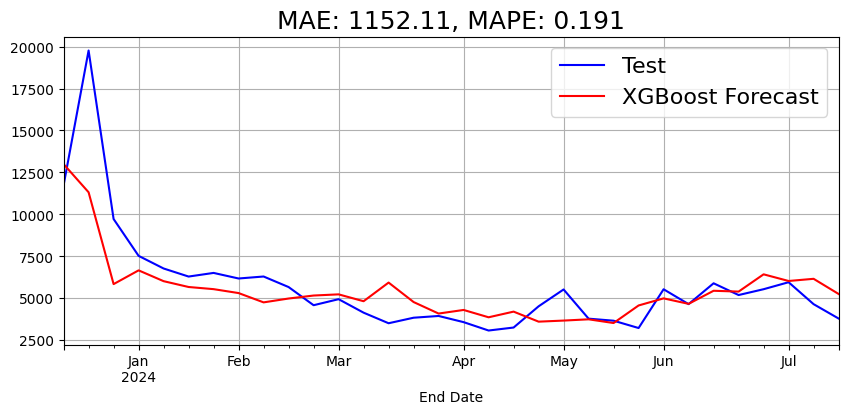

mae 1152.1064851434035
mape 19.073


In [ ]:
mae, mape = plot_prediction(ts_book1_train_subset_XGB, ts_book1_test, predictions_book1)

print("mae", mae)
print("mape", round(mape*100,3))

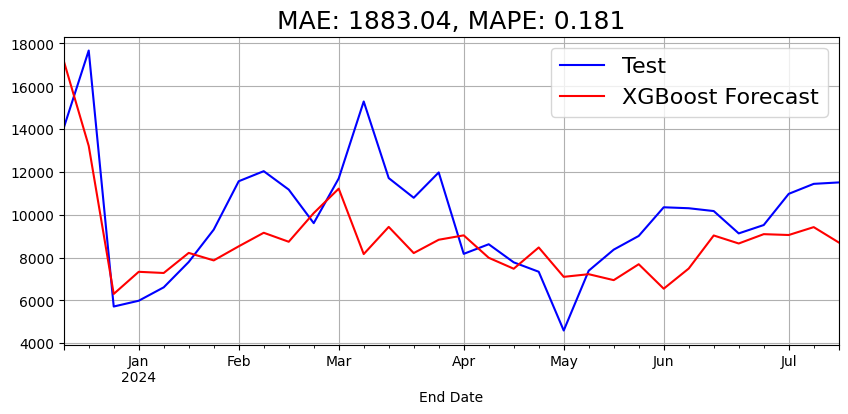

mae 1883.0421465991571
mape 18.096


In [ ]:
mae, mape = plot_prediction(ts_book2_train_subset_XGB, ts_book2_test, predictions_book2)

print("mae", mae)
print("mape", round(mape*100,3))

The predicting power of XGBoost based models is comparable to the ARIMA one - however, the tuning took significantly longer.

### Further XGBoost Analisys using Hyper-Opt

The time series datasets are partitioned into training and testing subsets based on a predefined forecasting horizon.


In [ ]:
### Run the model and obtain the results.
test_horizon = 52
train_set_xgb_123 = ts_book1.iloc[:-(test_horizon+4)]
test_set_xgb_123 = ts_book1.iloc[-(test_horizon+4):]
train_set_xgb_223 = ts_book2.iloc[:-(test_horizon+4)]
test_set_xgb_223 = ts_book2.iloc[-(test_horizon+4):]

An expanded hyperparameter search space for the XGBoost model is specified utilizing the `hyperopt` library. A function is defined to train and evaluate an XGBoost model using provided hyperparameters, with performance assessed via mean absolute error (MAE).

In [ ]:
### Expanded hyperparameter space
param_tuning_obj = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.quniform('reg_alpha', 0, 200, 1),
    'reg_lambda': hp.quniform('reg_lambda', 0, 200, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    #'window_size': hp.quniform('window_size', 4, 28, 4),
    'seed': 0
}

def auto_tune_training(params):
    train_set = train_set_xgb_223.values
    test_set = test_set_xgb_223.values

    #window_size = int(params['window_size'])

    train_input, train_output = create_input_output_sequences_xgb(4, 1, train_set)
    test_input, test_output = create_input_output_sequences_xgb(4, 1, test_set)

    model = XGBRegressor(
        n_estimators=100,
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        colsample_bytree=float(params['colsample_bytree']),
        subsample=float(params['subsample']),
        min_child_weight=int(params['min_child_weight']),
        learning_rate=params['learning_rate'],
        eval_metric="mae",
        early_stopping_rounds=10,
        random_state=int(params['seed'])
    )

    model.fit(
        train_input, train_output,
        eval_set=[(train_input, train_output), (test_input, test_output)],
        verbose=False
    )

    pred = model.predict(test_input)
    mae = mean_absolute_error(test_output, pred)
    print("MAE:", mae)

    return {'loss': mae, 'status': STATUS_OK}

Hyperparameter optimization is executed using the Tree-structured Parzen Estimator (TPE) algorithm across 600 iterations.

The cell was only run once for both books and the best combinations of hyperparameters were saved manually.


In [ ]:
"""
### Run the hyperparameter optimisation.
trials = Trials()

best_hyperparams = fmin(fn = auto_tune_training,
                        space = param_tuning_obj,
                        algo = tpe.suggest,
                        max_evals = 600,
                        trials = trials)

# Output of the hyperparameter optimisation.
print(best_hyperparams)
"""

'\n### Run the hyperparameter optimisation.\ntrials = Trials()\n\nbest_hyperparams = fmin(fn = auto_tune_training,\n                        space = param_tuning_obj,\n                        algo = tpe.suggest,\n                        max_evals = 600,\n                        trials = trials)\n\n# Output of the hyperparameter optimisation.\nprint(best_hyperparams)\n'

Previously identified optimal hyperparameter configurations for two distinct datasets are stored for subsequent model training.


In [ ]:
best_hp_previous_dict_book1 = {'colsample_bytree': 0.954047006232196, 'gamma': 4.403875556703955, 'learning_rate': 0.09751716856855316, 'max_depth': 6.0, 'min_child_weight': 3.0, 'reg_alpha': 32.0, 'reg_lambda': 38.0, 'subsample': 0.9725522660608016}
best_hp_previous_dict_book2 = {'colsample_bytree': 0.9406158759972593, 'gamma': 0.1589500461991905, 'learning_rate': 0.1699160631347035, 'max_depth': 12.0, 'min_child_weight': 5.0, 'reg_alpha': 143.0, 'reg_lambda': 188.0, 'subsample': 0.6084513099294926}

Three functions are created to perform the following operations:

1. Creating a parametric XGBoost Model
2. Making predictions with the previously defined model
3. A third function to combine the previous two and to create a workflow

In [ ]:
### Create a function for training XGBoost.
def xgboost_train(train_inputs, train_outputs):
 train_inputs = np.asarray(train_inputs)
 train_outputs = np.asarray(train_outputs).flatten()

 # Create the model.
 best_hp = best_hp_previous_dict_book2
 model = XGBRegressor(n_estimators=100,
                      min_child_weight=best_hp['min_child_weight'],
                      max_depth=int(best_hp['max_depth']),
                      learning_rate=best_hp['learning_rate'],
                      booster='gbtree',
                      tree_method='exact',
                      reg_alpha=best_hp['reg_alpha'],
                      reg_lambda=best_hp['reg_lambda'],
                      subsample=best_hp['subsample'],
                      validate_parameters=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      colsample_bytree=best_hp['colsample_bytree'],
                      gamma=best_hp['gamma'],
                      #objective='reg:squarederror'
                    )

 # Train the model.
 model.fit(train_inputs, train_outputs)

 return model

# Create a function for predicting with the fitted model.
def xgboost_predictions(model, test_input):
 prediction = model.predict(np.asarray([test_input]))

 return prediction[0]


# Create a function to manually perform the process of training and validation.
def walk_forward_validation(train_set, test_set):
  predictions = list()
  train_input, train_output = create_input_output_sequences_xgb(4, 1, train_set)
  test_input, test_output = create_input_output_sequences_xgb(4, 1, test_set)
  model = xgboost_train(train_input, train_output)
  for i in range(len(test_input)):
    prediction = xgboost_predictions(model, test_input[i])
    predictions.append(prediction)
    #print('>expected=%.1f, predicted=%.1f' % (test_output[i][0], prediction))

  #test_values = np.asarray(test_output).flatten()
  test_values = np.asarray(test_set).flatten()
  error = mean_absolute_percentage_error(np.asarray(test_output).flatten(), predictions)
  return error, np.asarray(test_output).flatten(), predictions

Predictions are generated for "Book B" with the previously optmized model

In [ ]:
###
mape, test_value, predictions = walk_forward_validation(train_set_xgb_223, test_set_xgb_223)
predictions_new_book2 = predictions[-32:]
predictions_new_series_book2 = pd.Series(predictions_new_book2, index=ts_book2_test.index)

The same steps are carried out for "Book A" book

In [ ]:
###
# Create a function for training XGBoost.
def xgboost_train(train_inputs, train_outputs):
 train_inputs = np.asarray(train_inputs)
 train_outputs = np.asarray(train_outputs).flatten()

 # Create the model.
 best_hp = best_hp_previous_dict_book1
 model = XGBRegressor(n_estimators=100,
                      min_child_weight=best_hp['min_child_weight'],
                      max_depth=int(best_hp['max_depth']),
                      learning_rate=best_hp['learning_rate'],
                      booster='gbtree',
                      tree_method='exact',
                      reg_alpha=best_hp['reg_alpha'],
                      reg_lambda=best_hp['reg_lambda'],
                      subsample=best_hp['subsample'],
                      validate_parameters=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      colsample_bytree=best_hp['colsample_bytree'],
                      gamma=best_hp['gamma'],
                      #objective='reg:squarederror'
                    )

 # Train the model.
 model.fit(train_inputs, train_outputs)

 return model

# Create a function for predicting with the fitted model.
def xgboost_predictions(model, test_input):
 prediction = model.predict(np.asarray([test_input]))

 return prediction[0]


# Create a function to manually perform the process of training and validation.
def walk_forward_validation(train_set, test_set):
  predictions = list()
  train_input, train_output = create_input_output_sequences_xgb(4, 1, train_set)
  test_input, test_output = create_input_output_sequences_xgb(4, 1, test_set)
  model = xgboost_train(train_input, train_output)
  for i in range(len(test_input)):
    prediction = xgboost_predictions(model, test_input[i])
    predictions.append(prediction)
    print('>expected=%.1f, predicted=%.1f' % (test_output[i][0], prediction))

  #test_values = np.asarray(test_output).flatten()
  test_values = np.asarray(test_set).flatten()
  error = mean_absolute_percentage_error(np.asarray(test_output).flatten(), predictions)
  return error, np.asarray(test_output).flatten(), predictions

In [ ]:
###
mape, test_value, predictions = walk_forward_validation(train_set_xgb_123, test_set_xgb_123)
predictions_new_book1 = predictions[-32:]
predictions_new_series_book1 = pd.Series(predictions_new_book1, index=ts_book1_test.index)

>expected=6345.6, predicted=5566.0
>expected=6437.4, predicted=6592.2
>expected=7107.7, predicted=6441.8
>expected=6098.8, predicted=6833.9
>expected=6801.3, predicted=5900.6
>expected=6568.7, predicted=7681.8
>expected=5467.5, predicted=6067.3
>expected=5847.5, predicted=5348.1
>expected=6607.3, predicted=5487.3
>expected=6204.1, predicted=7120.4
>expected=6430.1, predicted=5811.3
>expected=5396.8, predicted=6779.6
>expected=5589.8, predicted=4968.9
>expected=5742.7, predicted=5636.4
>expected=5908.3, predicted=5309.1
>expected=5724.0, predicted=5949.5
>expected=5450.7, predicted=6027.5
>expected=6063.2, predicted=5666.6
>expected=6753.6, predicted=6677.1
>expected=9269.3, predicted=8692.4
>expected=11730.9, predicted=10037.1
>expected=19766.7, predicted=7882.2
>expected=9717.4, predicted=7863.3
>expected=7520.4, predicted=7804.6
>expected=6766.4, predicted=6893.9
>expected=6285.3, predicted=6162.1
>expected=6502.2, predicted=5218.2
>expected=6169.7, predicted=5790.6
>expected=6287.9,

/tmp/ipython-input-4261528831.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('>expected=%.1f, predicted=%.1f' % (test_output[i][0], prediction))


A function is created to compare more than two time histories simultaneously

In [ ]:
def plot_prediction_mul(series_train, series_test, forecast, forecast2, labelslist, index, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    mae2 = mean_absolute_error(series_test, forecast2)
    mape2 = mean_absolute_percentage_error(series_test, forecast2)

    plt.figure(figsize=(10, 4))
    plt.title('XGBoost Comparison - {}'.format(index), size=12)
    #series_train.plot(label="Train", color="b")
    series_test.plot(label="Test", color="b")
    forecast.index = series_test.index
    forecast.plot(label=labelslist[0], color="r")
    forecast2.plot(label=labelslist[1], color="g")
    plt.xlabel('Date')
    plt.ylabel('Value')
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 12})
    plt.grid(True)
    plt.show()

    return mae, mape, mae2, mape2

Predictions and error metrics (MAE and MAPE) are plotted and compared with the grid-search optmized model

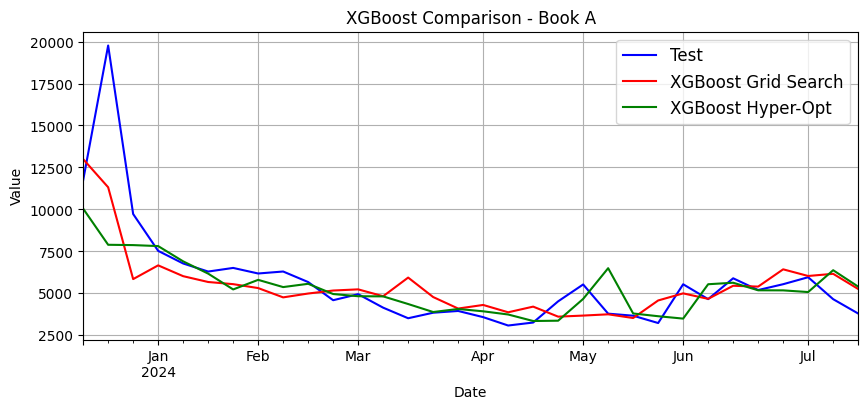

mae 1152.1064851434035
mape [%] 19.073
mae 1093.8148348999025
mape [%] 16.391


In [ ]:
###
mae, mape, mae2, mape2 = plot_prediction_mul(ts_book1_train_subset_XGB, ts_book1_test, predictions_book1, predictions_new_series_book1, ['XGBoost Grid Search','XGBoost Hyper-Opt'], 'Book A')

print("mae", mae)
print("mape [%]", round(mape*100,3))
print("mae", mae2)
print("mape [%]", round(mape2*100,3))

In [ ]:
summary_book_1['XGBoost HO'] = [mae2, round(mape2*100,2)]
summary_book_1['XGBoost GS'] = [mae, round(mape*100,2)]

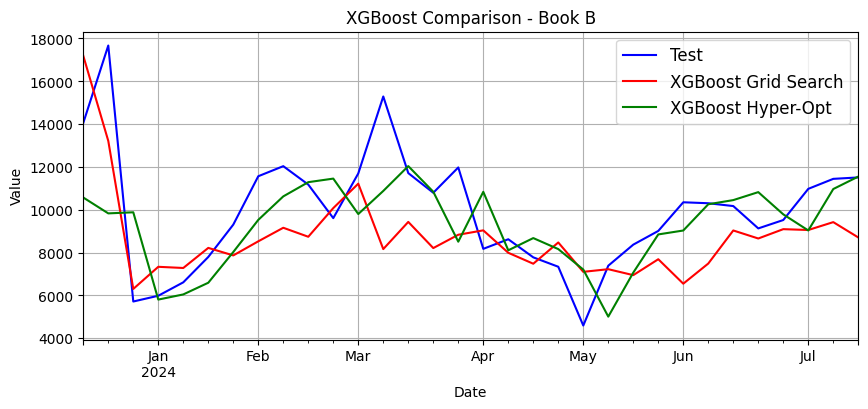

mae 1883.0421465991571
mape [%] 18.096
mae 1616.1650805664062
mape [%] 16.792


In [ ]:
mae, mape, mae2, mape2 = plot_prediction_mul(ts_book2_train_subset_XGB, ts_book2_test, predictions_book2, predictions_new_series_book2, ['XGBoost Grid Search','XGBoost Hyper-Opt'], 'Book B')

print("mae", mae)
print("mape [%]", round(mape*100,3))
print("mae", mae2)
print("mape [%]", round(mape2*100,3))

In [ ]:
summary_book_2['XGBoost HO'] = [mae2, round(mape2*100,2)]
summary_book_2['XGBoost GS'] = [mae, round(mape*100,2)]

### LSTM Modelling

A random seed is set

In [ ]:
tf.random.set_seed(0)

The function to create sequences from time series data is re-run in the cell below

In [ ]:
def create_input_sequences(lookback, forecast, sequence_data):
  input_sequences = []
  output_sequences = []

  for i in range(lookback, len(sequence_data) - forecast + 1):
      input_sequences.append(sequence_data[i - lookback: i])
      output_sequences.append(sequence_data[i: i + forecast])

  return { "input_sequences": input_sequences,"output_sequences": output_sequences }

**Book 1:**

The training data are normalized using MinMaxScaler to prepare for LSTM model input

In [ ]:
# Normalise the data.
ts_book1_sequence_data = ts_book1_train.copy()
ts_book1_sequence_data = ts_book1_sequence_data.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ts_book1_sequence_data)
ts_book1_sequence_data = scaler.transform(ts_book1_sequence_data)

Input-output sequences are constructed from the normalized data for supervised learning



In [ ]:
lookback = 104
forecast = 32
###
input_output_sequences_book1 = create_input_sequences(lookback, forecast, ts_book1_sequence_data)
input_sequences_book1 = np.array(input_output_sequences_book1["input_sequences"])
output_sequences_book1 = np.array(input_output_sequences_book1["output_sequences"])

multi_step_last_available_input_sequence_book1 = ts_book1_sequence_data[-lookback:]  # last available input sequence
multi_step_last_available_input_sequence_book1 = multi_step_last_available_input_sequence_book1.reshape(1, lookback, 1)

An LSTM model architecture is defined with hyperparameters to be tuned

In [ ]:
# Define the model for hyperparameter tuning.
def tuned_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=80,max_value=160,step=10),return_sequences=True, input_shape=(lookback, 1))) # 156 == lookback
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=80,max_value=160,step=10),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=80,max_value=160,step=10)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(forecast, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu'))) # 52 == forecast
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

A RandomSearch tuner is configured for hyperparameter optimization using mean squared error as the objective

The cells below were only run once and the best performing models were saved to *.h5* files and uploaded as needed

In [ ]:

tuner = RandomSearch(
        tuned_model,
        objective='mse',
        max_trials=50,
        executions_per_trial=1,
        overwrite=True
    )


Hyperparameter search is conducted on the training sequences to identify optimal configurations

In [ ]:

tuner.search(
        x=input_sequences_book1,
        y=output_sequences_book1,
        epochs=20,
        batch_size=32
)


Trial 50 Complete [00h 00m 15s]
mse: 0.015196457505226135

Best mse So Far: 0.011023158207535744
Total elapsed time: 00h 12m 48s


The best-performing hyperparameter set is retrieved from the tuner

In [ ]:

# Obtain the best parameters after tuning.
hp = tuner.get_best_hyperparameters()[0]
hp.values


{'input_unit': 100,
 'n_layers': 4,
 'lstm_0_units': 80,
 'layer_2_neurons': 160,
 'Dropout_rate': 0.4,
 'dense_activation': 'relu',
 'lstm_1_units': 150,
 'lstm_2_units': 90,
 'lstm_3_units': 140}

A final LSTM model is trained using the best-found hyperparameters

In [ ]:

multi_step_model_book1 = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
multi_step_model_book1.fit(input_sequences_book1, output_sequences_book1, epochs=250, batch_size=32, verbose=1)


Epoch 1/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0531 - mse: 0.0531
Epoch 2/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0212 - mse: 0.0212
Epoch 3/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0173 - mse: 0.0173
Epoch 4/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0164 - mse: 0.0164
Epoch 5/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0158 - mse: 0.0158
Epoch 6/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0152 - mse: 0.0152
Epoch 7/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0146 - mse: 0.0146
Epoch 8/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0139 - mse: 0.0139
Epoch 9/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0138 - mse: 0.0138
Epoch 10/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0138 - mse: 0.0138
Epoch 11/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0138 - mse: 0.0138
Epoch 12/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0133 - mse: 0.0133
Epoch 13/250
16/16 ━━━━━━

A pre-trained LSTM model is loaded from file, and its architecture is summarized

In [ ]:
from tensorflow import keras
#multi_step_model_book1 = keras.models.load_model(model_path+'Multi_step_model_Book1_02052025.h5')
multi_step_model_book1.save('Multi_step_model_Book1.h5')

In [ ]:
multi_step_model_book1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 104, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 104, 80)        │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 104, 150)       │       138,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 104, 90)        │        86,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 104, 140)       │       129,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 160)            │       192,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         5,152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953,698 (7.45 MB)

 Trainable params: 651,232 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,302,466 (4.97 MB)

Forecasts are generated using the final input sequence and subsequently inverse-transformed to the original scale.

In [ ]:
predictions_book1_LSTM = multi_step_model_book1.predict(multi_step_last_available_input_sequence_book1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


In [ ]:
predictions_book1_LSTM = predictions_book1_LSTM.reshape(-1, 1)
predictions_book1_LSTM = scaler.inverse_transform(predictions_book1_LSTM)

Predicted values are compared against actual test values and visualized for performance assessment

<Axes: title={'center': 'LSTM Forecast - Book A'}, xlabel='Date', ylabel='Value'>

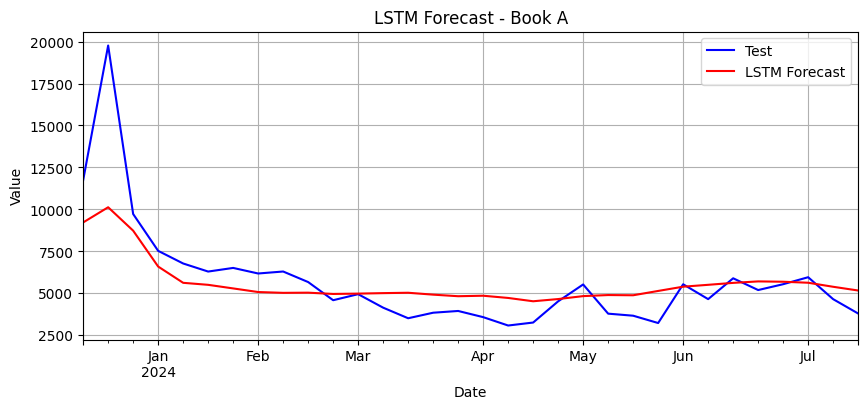

In [ ]:
comparison_book1 = ts_book1_test
#comparison_book1 = ts_book1.iloc[-forecast:]
comparison_book1 = pd.DataFrame(comparison_book1)
comparison_book1.rename(columns={'Value': 'Test'}, inplace=True)
comparison_book1['LSTM Forecast'] = predictions_book1_LSTM
comparison_book1.plot(grid=True, color=['blue','red'], figsize=(10, 4), title='LSTM Forecast - Book A', xlabel='Date', ylabel='Value')

Forecast accuracy is quantitatively evaluated using MAE and MAPE metrics

In [ ]:
mae_LSTM_book1 = mean_absolute_error(comparison_book1['Test'].to_numpy(), predictions_book1_LSTM)
mape_LSTM_book1 = mean_absolute_percentage_error(comparison_book1['Test'].to_numpy(), predictions_book1_LSTM)
print("mae", mae_LSTM_book1)
print("mape", mape_LSTM_book1)

mae 1208.1585833740235
mape 0.21153921506398315


In [ ]:
summary_book_1['LSTM'] = [mae_LSTM_book1, round(mape_LSTM_book1*100,2)]

**Book 2:**

The same steps are repeated for "Book B" book

In [ ]:
# Normalise the data.
ts_book2_sequence_data = ts_book2_train.copy()
ts_book2_sequence_data = ts_book2_sequence_data.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ts_book2_sequence_data)
ts_book2_sequence_data = scaler.transform(ts_book2_sequence_data)

In [ ]:
lookback = 54
forecast = 32
###
input_output_sequences_book2 = create_input_sequences(lookback, forecast, ts_book2_sequence_data)
input_sequences_book2 = np.array(input_output_sequences_book2["input_sequences"])
output_sequences_book2 = np.array(input_output_sequences_book2["output_sequences"])

multi_step_last_available_input_sequence_book2 = ts_book2_sequence_data[-lookback:]  # last available input sequence
multi_step_last_available_input_sequence_book2 = multi_step_last_available_input_sequence_book2.reshape(1, lookback, 1)

In [ ]:
# Define the model for hyperparameter tuning.
def tuned_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=64,max_value=512,step=64),return_sequences=True, input_shape=(lookback, 1))) # 156 == lookback
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=64,max_value=512,step=64),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=64,max_value=512,step=64)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(forecast, activation='linear')) # 52 == forecast
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [ ]:

tuner = RandomSearch(
        tuned_model,
        objective='mse',
        max_trials=20,
        executions_per_trial=1,
        overwrite=True
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

tuner.search(
        x=input_sequences_book2,
        y=output_sequences_book2,
        epochs=10,
        batch_size=32
)


Trial 20 Complete [00h 00m 11s]
mse: 0.013328424654901028

Best mse So Far: 0.013057408854365349
Total elapsed time: 00h 04m 25s


In [ ]:

# Obtain the best parameters after tuning.
hp = tuner.get_best_hyperparameters()[0]
hp.values


{'input_unit': 64,
 'n_layers': 3,
 'lstm_0_units': 256,
 'layer_2_neurons': 256,
 'Dropout_rate': 0.0,
 'lstm_1_units': 448,
 'lstm_2_units': 128,
 'lstm_3_units': 320}

In [ ]:

multi_step_model_book2 = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])


In [ ]:

multi_step_model_book2.fit(input_sequences_book2, output_sequences_book2, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0639 - mse: 0.0639
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0241 - mse: 0.0241
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0147 - mse: 0.0147
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0136 - mse: 0.0136
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0136 - mse: 0.0136
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0132 - mse: 0.0132
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0130 - mse: 0.0130
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0128 - mse: 0.0128
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0128 - mse: 0.0128
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0130 - mse: 0.0130
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0132 - mse: 0.0132
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0133 - mse: 0.0133
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste

In [ ]:
from tensorflow import keras
#multi_step_model_book2 = keras.models.load_model(model_path+'Multi_step_model_Book2_02052025.h5')
multi_step_model_book2.save(model_path+'Multi_step_model_Book2_02052025.h5')

In [ ]:
multi_step_model_book2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 54, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 54, 256)        │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 54, 448)        │     1,263,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 54, 128)        │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,920,546 (26.40 MB)

 Trainable params: 2,306,848 (8.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,613,698 (17.60 MB)

In [ ]:
predictions_book2_LSTM = multi_step_model_book2.predict(multi_step_last_available_input_sequence_book2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


In [ ]:
predictions_book2_LSTM = predictions_book2_LSTM.reshape(-1, 1)
predictions_book2_LSTM = scaler.inverse_transform(predictions_book2_LSTM)

<Axes: title={'center': 'LSTM Forecast - Book B'}, xlabel='Date', ylabel='Value'>

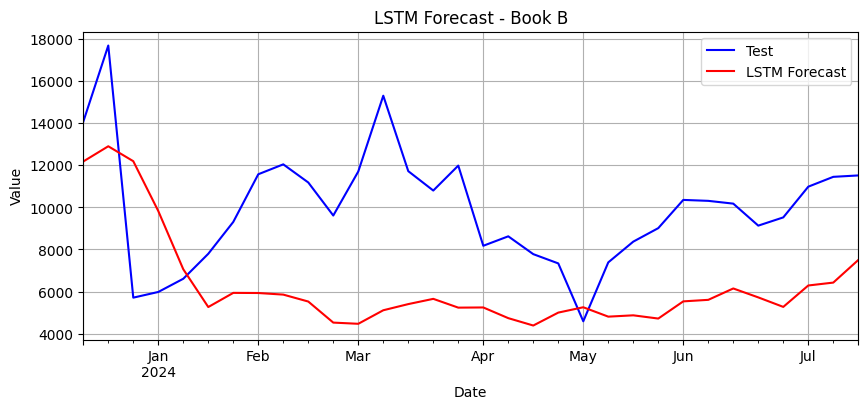

In [ ]:
comparison_book2 = ts_book2_test
comparison_book2 = pd.DataFrame(comparison_book2)
comparison_book2.rename(columns={'Value': 'Test'}, inplace=True)
comparison_book2['LSTM Forecast'] = predictions_book2_LSTM
comparison_book2.plot(grid=True, color=['blue','red'], figsize=(10, 4), title='LSTM Forecast - Book B', xlabel='Date', ylabel='Value')

In [ ]:
mae_LSTM_book2 = mean_absolute_error(comparison_book2['Test'].to_numpy(), predictions_book2_LSTM)
mape_LSTM_book2 = mean_absolute_percentage_error(comparison_book2['Test'].to_numpy(), predictions_book2_LSTM)
print("mae", round(mae_LSTM_book2,3))
print("mape", round(mape_LSTM_book2*100, 3), "%")

mae 4371.276
mape 44.151 %


In [ ]:
summary_book_2['LSTM'] = [mae_LSTM_book2, round(mape_LSTM_book2*100, 2)]

### LSTM - part 2

In the cells below, a second LSTM architecture is explored, with the introduction of time features in the data and a lighter LSTM model.

**Disclaimer:** this part was introduced at a later stage with respect to the rest of the code

This function prepares the data for the LSTM model, adding time features (year and week) to better address the time dependancy of the data

In [ ]:
def prepare_LSTM_data_with_time_features(df, target_col, window_size=52):
    df = pd.DataFrame(df)
    df.index = pd.to_datetime(df.index)  # Ensure datetime index
    df = df.sort_index()  # Sort chronologically

    # Safely extract week and year from the index
    iso = df.index.isocalendar()
    df['week_of_year'] = iso.week
    df['year'] = iso.year

    values = df[target_col].values
    weeks = df['week_of_year'].values
    years = df['year'].values

    X, y = [], []

    for i in range(window_size, len(df)):
        val_window = values[i - window_size:i]
        week_window = weeks[i - window_size:i]
        year_window = years[i - window_size:i]

        features = np.stack([val_window, week_window, year_window], axis=1)
        X.append(features)
        y.append(values[i])

    return np.array(X), np.array(y)

**Book 1:**

Train and test split is performed

In [ ]:
from keras import layers

lookback = 52
forecast = 32

X_all, y_all = prepare_LSTM_data_with_time_features(ts_book1, target_col='Value', window_size=lookback)

X_train_book1 = X_all[:-forecast]
X_test_book1  = X_all[-forecast:]
y_train_book1 = y_all[:-forecast]
y_test_book1  = y_all[-forecast:]

Input and output data is scaled and further prepared

In [ ]:
n_steps = X_train_book1.shape[1]
n_features = X_train_book1.shape[2]

X_train_flat = X_train_book1.reshape(-1, n_features)
X_test_flat = X_test_book1.reshape(-1, n_features)

scaler_X = MinMaxScaler()
X_train_flat = scaler_X.fit_transform(X_train_flat)
X_test_flat = scaler_X.transform(X_test_flat)

X_train_book1 = X_train_flat.reshape(-1, n_steps, n_features)
X_test_book1  = X_test_flat.reshape(-1, n_steps, n_features)

scaler_y = MinMaxScaler()
y_train_book1 = scaler_y.fit_transform(y_train_book1.reshape(-1, 1))
#y_test_book1  = scaler_y.transform(y_test_book1.reshape(-1, 1))

The function creating the tuneable model with the new architecture is defined below

In [ ]:
from tensorflow.keras.losses import Huber

def tuned_model_new_architecture(hp):
    model = keras.Sequential()

    model.add(layers.LSTM(units=hp.Int('units', min_value=64, max_value=512, step=64),activation='tanh',
        return_sequences=hp.Boolean('stacked'),input_shape=(n_steps, n_features)))

    if hp.Boolean('stacked'):
        model.add(layers.LSTM(units=hp.Int('units2', min_value=64, max_value=256, step=64),activation='tanh'))

    model.add(layers.Dropout(rate=hp.Float('dropout', 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(units=1, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('lr', [0.005, 0.001, 0.0005]),clipnorm=1.0)

    model.compile(optimizer=optimizer,loss=Huber(),metrics=['mean_absolute_error'])
    return model

The hyperparameter tuning is performend with Keras RandomSearch, adding an early stopping logic on the validation loss

In [ ]:
tuner = RandomSearch(
    tuned_model_new_architecture,
    objective='val_mean_absolute_error',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuner_book1',
    project_name='book1_lstm',
    overwrite=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search_space_summary()
tuner.search(
    X_train_book1, y_train_book1,
    epochs=20,
    validation_split=0.2,
    callbacks=[es]
)


Trial 10 Complete [00h 00m 16s]
val_mean_absolute_error: 0.047639183700084686

Best val_mean_absolute_error So Far: 0.04570936784148216
Total elapsed time: 00h 01m 52s


The best performing model is then re-runed on a larger number of epochs and eventually saved to a *.h5* file

In [ ]:

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_hp = tuner.get_best_hyperparameters()[0]
model_lstm_2_book1 = tuned_model_new_architecture(best_hp)
model_lstm_2_book1.fit(X_train_book1, y_train_book1,epochs=100,validation_split=0.2,callbacks=[es])


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0264 - mean_absolute_error: 0.1680 - val_loss: 0.0097 - val_mean_absolute_error: 0.1050
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0062 - mean_absolute_error: 0.0752 - val_loss: 0.0058 - val_mean_absolute_error: 0.0649
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0052 - mean_absolute_error: 0.0651 - val_loss: 0.0056 - val_mean_absolute_error: 0.0620
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050 - mean_absolute_error: 0.0626 - val_loss: 0.0057 - val_mean_absolute_error: 0.0613
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0046 - mean_absolute_error: 0.0585 - val_loss: 0.0056 - val_mean_absolute_error: 0.0618
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0045 - mean_absolute_error: 0.0561 - val_loss: 0.0058 - val_mean_absolute_error: 0.0648
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0573 - v

The best performing model from previous training is loaded from an *.h5* file

In [ ]:
#model_lstm_2_book1 = keras.models.load_model(model_path+'LSTM_TimeFeatures_Book1_09052025.h5')
model_lstm_2_book1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,141 (793.52 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 135,428 (529.02 KB)

Predictions are performed with the new model and compared against test data. Error metrics MAE and MAPE are also calculated.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
LSTM MAE:  1097.98
LSTM MAPE:16.11%


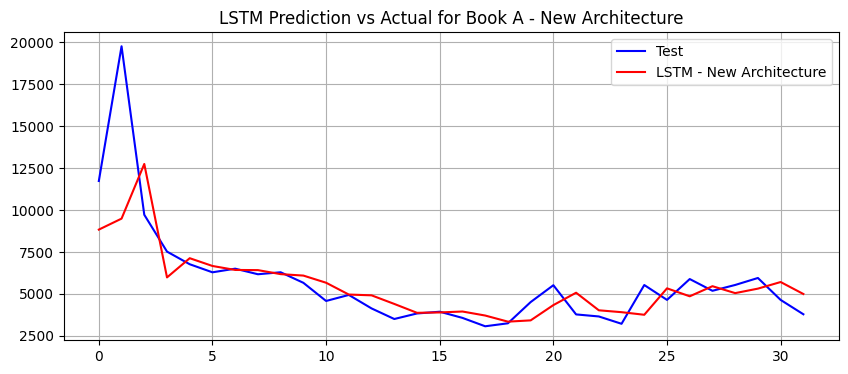

In [ ]:
y_pred_s = model_lstm_2_book1.predict(X_test_book1)
y_pred_na_book1   = scaler_y.inverse_transform(y_pred_s).ravel()

mae_lstm_2_book1  = mean_absolute_error(y_test_book1, y_pred_na_book1)
mape_lstm_2_book1 = np.mean(np.abs((y_test_book1 - y_pred_na_book1) / y_test_book1)) * 100

print(f"LSTM MAE:  {mae_lstm_2_book1:.2f}")
print(f"LSTM MAPE:{mape_lstm_2_book1:.2f}%")

summary_book_1['LSTM - 2'] = [mae_lstm_2_book1, (mape_lstm_2_book1).round(2)]

plt.figure(figsize=(10,4))
plt.plot(y_test_book1, label='Test', color='blue')
plt.plot(y_pred_na_book1, label='LSTM - New Architecture', color='red')
plt.legend()
plt.grid(True)
plt.title('LSTM Prediction vs Actual for Book A - New Architecture')
plt.show()

#model.save(model_path+'LSTM_TimeFeatures_Book1_09052025.h5')

The same steps are repeated for book 2

**Book 2:**



In [ ]:
lookback = 52  # number of past weeks to use as input

X_all, y_all = prepare_LSTM_data_with_time_features(ts_book2, target_col='Value', window_size=lookback)

# Define your test size (e.g., last 32 weeks)
forecast = 32

# Split into training and testing sets
X_train_book2 = X_all[:-forecast]
X_test_book2  = X_all[-forecast:]
y_train_book2 = y_all[:-forecast]
y_test_book2  = y_all[-forecast:]

In [ ]:
n_steps = X_train_book2.shape[1]
n_features = X_train_book2.shape[2]

X_train_flat = X_train_book2.reshape(-1, n_features)
X_test_flat = X_test_book2.reshape(-1, n_features)

scaler_X = MinMaxScaler()
X_train_flat = scaler_X.fit_transform(X_train_flat)
X_test_flat = scaler_X.transform(X_test_flat)

X_train_book2 = X_train_flat.reshape(-1, n_steps, n_features)
X_test_book2  = X_test_flat.reshape(-1, n_steps, n_features)

scaler_y = MinMaxScaler()
y_train_book2 = scaler_y.fit_transform(y_train_book2.reshape(-1, 1))

In [ ]:
def tuned_model_new_architecture(hp):
    model = keras.Sequential()

    model.add(layers.LSTM(units=hp.Int('units', min_value=64, max_value=512, step=64),activation='tanh',
        return_sequences=hp.Boolean('stacked'),input_shape=(n_steps, n_features)))

    if hp.Boolean('stacked'):
        model.add(layers.LSTM(units=hp.Int('units2', min_value=64, max_value=256, step=64),activation='tanh'))

    model.add(layers.Dropout(rate=hp.Float('dropout', 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(units=1, activation='linear'))

    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('lr', [0.005, 0.001, 0.0005]),clipnorm=1.0)

    model.compile(optimizer=optimizer,loss=Huber(),metrics=['mean_absolute_error'])
    return model

In [ ]:
tuner = RandomSearch(
    tuned_model_new_architecture,
    objective='val_mean_absolute_error',
    max_trials=50,
    executions_per_trial=1,
    directory='lstm_tuner_caterpillar',
    project_name='caterpillar_lstm'
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

tuner.search_space_summary()
tuner.search(
    X_train_book2, y_train_book2,
    epochs=20,
    validation_split=0.2,
    callbacks=[es]
)


Trial 50 Complete [00h 00m 12s]
val_mean_absolute_error: 0.06286034733057022

Best val_mean_absolute_error So Far: 0.060618139803409576
Total elapsed time: 00h 10m 23s


In [ ]:

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_hp = tuner.get_best_hyperparameters()[0]
model_lstmna_book2 = tuned_model_new_architecture(best_hp)
model_lstmna_book2.fit(X_train_book2, y_train_book2,epochs=50,validation_split=0.2,callbacks=[es])


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0441 - mean_absolute_error: 0.2254 - val_loss: 0.0150 - val_mean_absolute_error: 0.1294
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127 - mean_absolute_error: 0.1131 - val_loss: 0.0089 - val_mean_absolute_error: 0.1055
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0112 - mean_absolute_error: 0.0967 - val_loss: 0.0083 - val_mean_absolute_error: 0.0935
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - mean_absolute_error: 0.0905 - val_loss: 0.0082 - val_mean_absolute_error: 0.0911
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - mean_absolute_error: 0.0889 - val_loss: 0.0079 - val_mean_absolute_error: 0.0909
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0096 - mean_absolute_error: 0.0864 - val_loss: 0.0077 - val_mean_absolute_error: 0.0887
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - mean_absolute_error: 0.0846 - val_loss

In [ ]:
#model_lstmna_book2 = keras.models.load_model(model_path+'LSTM_TimeFeatures_Book2_09052025.h5')
model_lstmna_book2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 192)            │       150,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,165 (1.72 MB)

 Trainable params: 150,721 (588.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,444 (1.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
LSTM MAE:  1557.64
LSTM MAPE: 18.34%


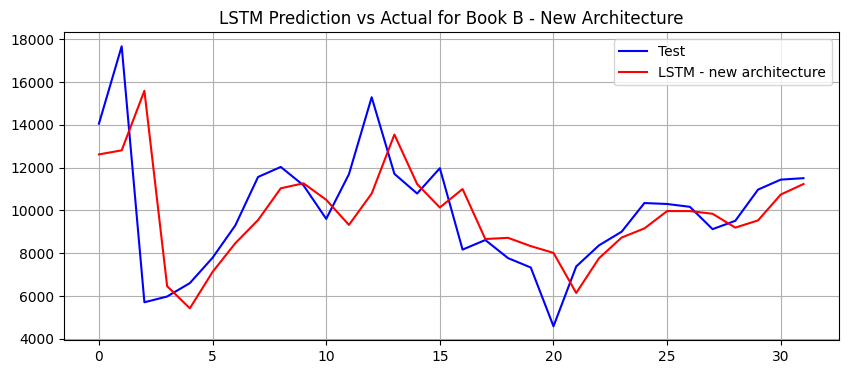

In [ ]:
y_pred_s = model_lstmna_book2.predict(X_test_book2)
y_pred_na_book2   = scaler_y.inverse_transform(y_pred_s).ravel()

mae  = mean_absolute_error(y_test_book2, y_pred_na_book2)
mape = np.mean(np.abs((y_test_book2 - y_pred_na_book2) / y_test_book2)) * 100

print(f"LSTM MAE:  {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")

summary_book_2['LSTM - 2'] = [mae, (mape).round(2)]

plt.figure(figsize=(10,4))
plt.plot(y_test_book2, label='Test', color='blue')
plt.plot(y_pred_na_book2, label='LSTM - new architecture', color='red')
plt.legend()
plt.title('LSTM Prediction vs Actual for Book B - New Architecture')
plt.grid(True)
plt.show()

model_lstmna_book2.save(model_path+'LSTM_TimeFeatures_Book2_09052025.h5')

In [ ]:
def plot_prediction_mul(series_train, series_test, forecast, forecast2, labelslist, index, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    mae2 = mean_absolute_error(series_test, forecast2)
    mape2 = mean_absolute_percentage_error(series_test, forecast2)

    plt.figure(figsize=(10, 4))
    plt.title('LSTM Architectures Comparison - {}'.format(index), size=12)
    #series_train.plot(label="Train", color="b")
    series_test.plot(label="Test", color="b")
    forecast.index = series_test.index
    forecast.plot(label=labelslist[0], color="r")
    forecast2.plot(label=labelslist[1], color="g")
    plt.xlabel('Date')
    plt.ylabel('Value')
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 12})
    plt.grid(True)
    plt.show()

    return mae, mape, mae2, mape2

A comparison is provided between LSTM architecture 1 and 2

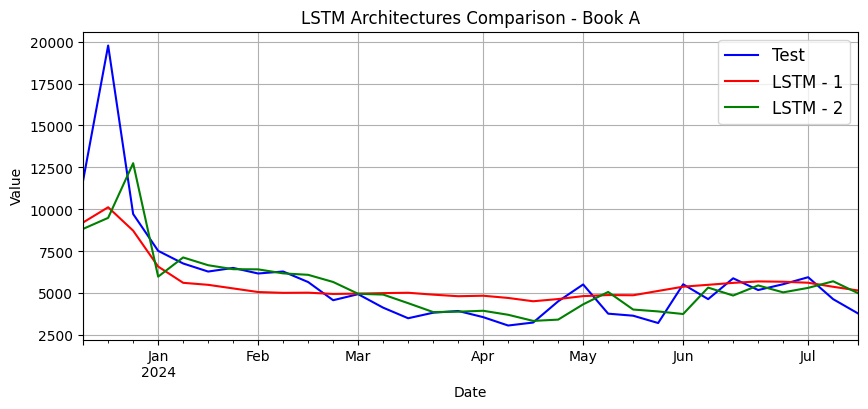

mae 1208.1585833740235
mape [%] 21.154
mae 1097.9781341552734
mape [%] 16.109


In [ ]:
###
mae, mape, mae2, mape2 = plot_prediction_mul(ts_book1_train_subset_XGB, ts_book1_test, pd.Series(predictions_book1_LSTM.flatten(),index=ts_book1_test.index), pd.Series(y_pred_na_book1,index=ts_book1_test.index), ['LSTM - 1','LSTM - 2'], 'Book A')

print("mae", mae)
print("mape [%]", round(mape*100,3))
print("mae", mae2)
print("mape [%]", round(mape2*100,3))

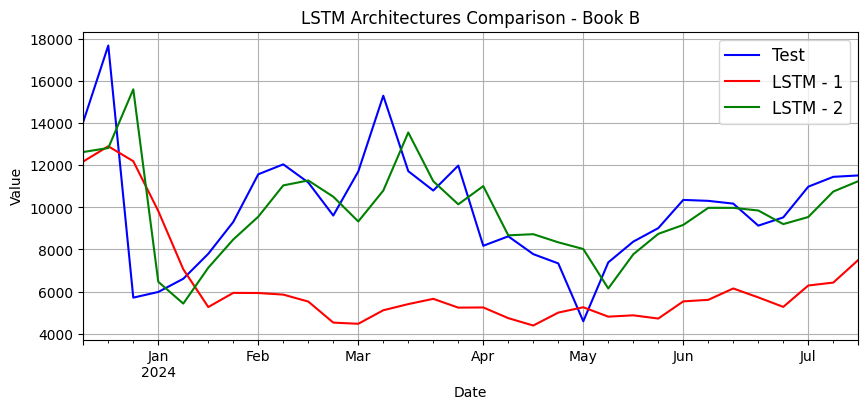

mae 4371.276310424804
mape [%] 44.151
mae 1557.6388494873045
mape [%] 18.34


In [ ]:
###
mae, mape, mae2, mape2 = plot_prediction_mul(ts_book1_train_subset_XGB, ts_book2_test, pd.Series(predictions_book2_LSTM.flatten(),index=ts_book2_test.index), pd.Series(y_pred_na_book2,index=ts_book2_test.index), ['LSTM - 1','LSTM - 2'], 'Book B')

print("mae", mae)
print("mape [%]", round(mape*100,3))
print("mae", mae2)
print("mape [%]", round(mape2*100,3))

### Hybrid Modelling - Sequential

Residuals from the auto arima models are recalculated for "Book A"

In [ ]:
residuals_test_book1 = ts_book1_test - autoarima_model.predict(n_periods=32, return_conf_int=False)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Data is prepared for the LSTM model as done previously

In [ ]:
# Normalise the data.
residuals_book1_sequence_data = residuals_ts1.copy()
residuals_book1_sequence_data = residuals_book1_sequence_data.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(residuals_book1_sequence_data)
residuals_book1_sequence_data = scaler.transform(residuals_book1_sequence_data)

As the residuals do not have seasonality, a smaller lookback window was adopted to simplify the model and reduce the associated computational effort

In [ ]:
lookback = 54
forecast = 32
###
input_output_sequences_residuals_book1 = create_input_sequences(lookback, forecast, residuals_book1_sequence_data)
input_sequences_residuals_book1 = np.array(input_output_sequences_residuals_book1["input_sequences"])
output_sequences_residuals_book1 = np.array(input_output_sequences_residuals_book1["output_sequences"])

multi_step_last_available_input_sequence_residuals_book1 = residuals_book1_sequence_data[-lookback:]  # last available input sequence
multi_step_last_available_input_sequence_residuals_book1 = multi_step_last_available_input_sequence_residuals_book1.reshape(1, lookback, 1)

A parametric model for the tuning is defined

In [ ]:
# Define the model for hyperparameter tuning.
def tuned_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=64,max_value=512,step=64),return_sequences=True, input_shape=(lookback, 1))) # 156 == lookback
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=64,max_value=512,step=64),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=64,max_value=512,step=64)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(forecast, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid', 'tanh'],default='relu'))) # 52 == forecast
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

The Keras tuner is also defined. As the residuals present a more random/chaotic nature, it was decided to try the Bayesian Optimization algorithm for the hyperparameter tuning. A relatively high number of trials (40) was set along with a small number of epochs for each trials, to compare different hyperparameter settings more easily. The best model will then be trained with a higher number of epochs

In [ ]:

tuner = BayesianOptimization(
        tuned_model,
        objective='mse',
        max_trials=40,
        executions_per_trial=1,
        overwrite=True
    )


A 20% validation split, with an early stopping callback is also introduced to save on computational efforts and prevent overfitting

In [ ]:

tuner.search(
        x=input_sequences_residuals_book1,
        y=output_sequences_residuals_book1,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)


Trial 40 Complete [00h 00m 16s]
mse: 0.005534254480153322

Best mse So Far: 0.005055226385593414
Total elapsed time: 00h 12m 47s


A new model is built from the best hyperparameter set and fit to the residual data with a much higher number of epochs (600). The model is then saved to a *.h5* file

In [ ]:

# Obtain the best parameters after tuning.
hp = tuner.get_best_hyperparameters()[0]
hp.values


{'input_unit': 128,
 'n_layers': 3,
 'lstm_0_units': 448,
 'layer_2_neurons': 128,
 'Dropout_rate': 0.0,
 'dense_activation': 'sigmoid',
 'lstm_1_units': 448,
 'lstm_2_units': 64,
 'lstm_3_units': 256}

In [ ]:

multi_step_model_rs_book1 = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])


In [ ]:

multi_step_model_rs_book1.fit(input_sequences_residuals_book1, output_sequences_residuals_book1, epochs=500, batch_size=64, verbose=1)


Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0290 - mse: 0.0290
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0063 - mse: 0.0063
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0056 - mse: 0.0056
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0052 - mse: 0.0052
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0052 - mse: 0.0052
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0051 - mse: 0.0051
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0051 - mse: 0.0051
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0050 - mse: 0.0050
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0050 - mse: 0.0050
Epoch 10/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0050 - mse: 0.0050
Epoch 11/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0050 - mse: 0.0050
Epoch 12/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0050 - mse: 0.0050
Epoch 13/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/ste

The tuned model is loaded from a previously generated *.h5* file

In [ ]:
#multi_step_model_rs_book1 = keras.models.load_model(model_path+'Residuals_Book1.h5')

A summary is generated

In [ ]:
multi_step_model_rs_book1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 54, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 54, 448)        │     1,033,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 54, 448)        │     1,607,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 54, 64)         │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,826,722 (33.67 MB)

 Trainable params: 2,942,240 (11.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,884,482 (22.45 MB)

Predictions are generated with the newly tuned model

In [ ]:
predicted_residuals_book1 = multi_step_model_rs_book1.predict(multi_step_last_available_input_sequence_residuals_book1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


Results are scaled back to their original size

In [ ]:
predicted_residuals_book1 = predicted_residuals_book1.reshape(-1, 1)
predicted_residuals_book1 = scaler.inverse_transform(predicted_residuals_book1)

The results from ARIMA and LSTM are summed and plotted

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


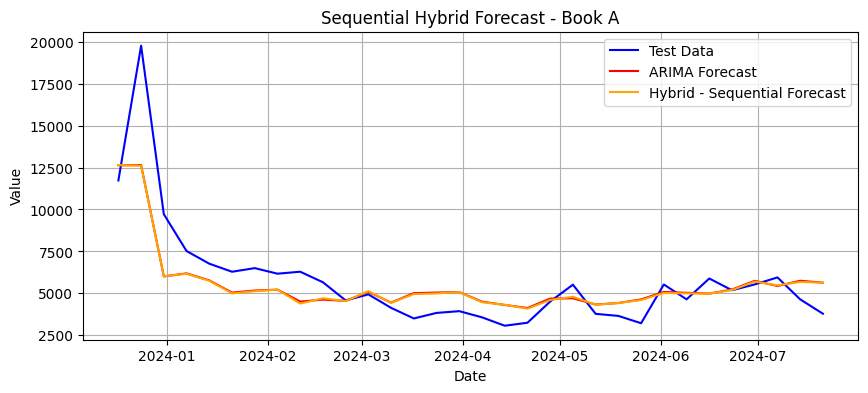

In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr_book1 = autoarima_model.predict(n_periods=32, return_conf_int=False)
forecast_arr_book1.index = ts_book1_test.index
predicted_residuals_book1 = pd.Series(predicted_residuals_book1.flatten(), index=forecast_arr.index)
hybrid_sequential_prediction_book1 = forecast_arr_book1 + predicted_residuals_book1

# Step 2: Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_book1_test, label="Test Data", color="blue")
plt.plot(forecast_arr_book1, label="ARIMA Forecast", color="red")
plt.plot(hybrid_sequential_prediction_book1, label="Hybrid - Sequential Forecast", color="orange")
plt.title("Sequential Hybrid Forecast - Book A")
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

The MAE and MAPE metrics are generated and saved

In [ ]:
mae_hybrid_sequential_book1 = mean_absolute_error(ts_book1_test, hybrid_sequential_prediction_book1)
mape_hybrid_sequential_book1 = mean_absolute_percentage_error(ts_book1_test, hybrid_sequential_prediction_book1)
print("mae", mae_hybrid_sequential_book1)
print("mape", mape_hybrid_sequential_book1)

mae 1147.6417882356827
mape 0.1976524525295547


In [ ]:
summary_book_1['Hybrid - s'] = [mae_hybrid_sequential_book1, round(mape_hybrid_sequential_book1*100, 2)]

**Book 2:**

The same steps are repeated for "Book B" book

In [ ]:
residuals_test_book2 = ts_book1_test - autoarima_model_2.predict(n_periods=32, return_conf_int=False)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Normalise the data.
residuals_book2_sequence_data = residuals_ts2.copy()
residuals_book2_sequence_data = residuals_book2_sequence_data.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(residuals_book2_sequence_data)
residuals_book2_sequence_data = scaler.transform(residuals_book2_sequence_data)

In [ ]:
lookback = 54
forecast = 32
###
input_output_sequences_residuals_book2 = create_input_sequences(lookback, forecast, residuals_book2_sequence_data)
input_sequences_residuals_book2 = np.array(input_output_sequences_residuals_book2["input_sequences"])
output_sequences_residuals_book2 = np.array(input_output_sequences_residuals_book2["output_sequences"])

multi_step_last_available_input_sequence_residuals_book2 = residuals_book2_sequence_data[-lookback:]  # last available input sequence
multi_step_last_available_input_sequence_residuals_book2 = multi_step_last_available_input_sequence_residuals_book2.reshape(1, lookback, 1)

In [ ]:
# Define the model for hyperparameter tuning.
def tuned_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=64,max_value=512,step=64),return_sequences=True, input_shape=(lookback, 1))) # 156 == lookback
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=64,max_value=512,step=64),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=64,max_value=512,step=64)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(forecast, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid', 'tanh'],default='relu'))) # 52 == forecast
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [ ]:

tuner = BayesianOptimization(
        tuned_model,
        objective='mse',
        max_trials=40,
        executions_per_trial=1,
        overwrite=True
    )


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

tuner.search(
        x=input_sequences_residuals_book2,
        y=output_sequences_residuals_book2,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)


Trial 40 Complete [00h 00m 21s]
mse: 0.0072200545109808445

Best mse So Far: 0.0072200545109808445
Total elapsed time: 00h 21m 14s


In [ ]:

# Obtain the best parameters after tuning.
hp = tuner.get_best_hyperparameters()[0]
hp.values


{'input_unit': 64,
 'n_layers': 1,
 'lstm_0_units': 128,
 'layer_2_neurons': 512,
 'Dropout_rate': 0.0,
 'dense_activation': 'tanh',
 'lstm_1_units': 192,
 'lstm_2_units': 512,
 'lstm_3_units': 512}

In [ ]:

multi_step_model_rs_book2 = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])


In [ ]:

multi_step_model_rs_book2.fit(input_sequences_residuals_book2, output_sequences_residuals_book2, epochs=200, batch_size=64, verbose=1, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.1308 - mse: 0.1308 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0073 - mse:

In [ ]:
#multi_step_model_rs_book2 = keras.models.load_model(model_path+'Residuals_Book2.h5')

In [ ]:
multi_step_model_rs_book2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 54, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 54, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 512)            │     1,312,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,334,690 (16.54 MB)

 Trainable params: 1,444,896 (5.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,889,794 (11.02 MB)

In [ ]:
predicted_residuals_book2 = multi_step_model_rs_book2.predict(multi_step_last_available_input_sequence_residuals_book2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


In [ ]:
predicted_residuals_book2 = predicted_residuals_book2.reshape(-1, 1)
predicted_residuals_book2 = scaler.inverse_transform(predicted_residuals_book2)

In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr_book2 = autoarima_model_2.predict(n_periods=32, return_conf_int=False)
forecast_arr_book2.index = ts_book2_test.index
predicted_residuals_book2 = pd.Series(predicted_residuals_book2.flatten(), index=forecast_arr_book2.index)
hybrid_sequential_prediction_book2 = forecast_arr_book2 + predicted_residuals_book2

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


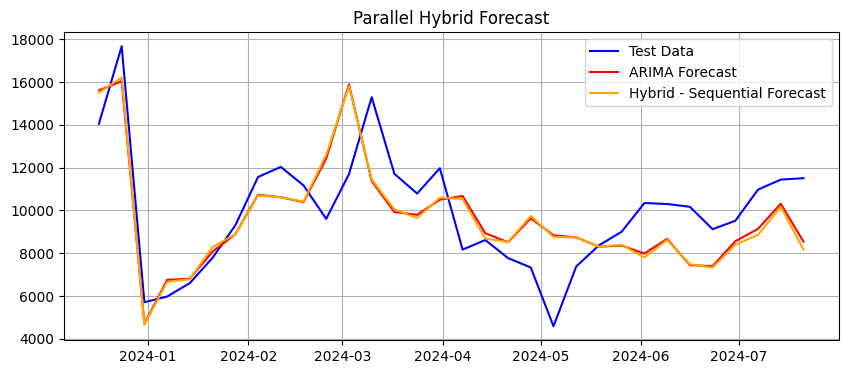

mae 1632.5001438117224
mape 0.175910597891297


In [ ]:
# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_book2_test, label="Test Data", color="blue")
plt.plot(forecast_arr_book2, label="ARIMA Forecast", color="red")
plt.plot(hybrid_sequential_prediction_book2, label="Hybrid - Sequential Forecast", color="orange")
plt.title("Parallel Hybrid Forecast")
plt.grid(True)
plt.legend()
plt.show()

mae_hybrid_sequential_book2 = mean_absolute_error(ts_book2_test, hybrid_sequential_prediction_book2)
mape_hybrid_sequential_book2 = mean_absolute_percentage_error(ts_book2_test, hybrid_sequential_prediction_book2)
print("mae", mae_hybrid_sequential_book2)
print("mape", mape_hybrid_sequential_book2)

In [ ]:
summary_book_2['Hybrid - S'] = [mae_hybrid_sequential_book2, round(mape_hybrid_sequential_book2*100, 2)]

### Hybrid Modelling - Parallel

**Book 1:**

ARIMA forecast is recalculated with the previously defined model

In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr, conf_int_arr = autoarima_model.predict(n_periods=n_forecast_periods, return_conf_int=True)

# Step 2: Ensure index alignment
forecast_index = ts_book1_test.index

# Step 3: Create numeric Series/DataFrames with clean data
forecast_ARIMA = pd.Series(forecast_arr, index=forecast_index)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


A range of weighted combinations of ARIMA and LSTM forecasts is constructed, and the Mean Absolute Percentage Error (MAPE) is computed for each weight. The weight that minimizes the MAPE is identified, and the relationship between forecast weight and MAPE is visualized.

In [ ]:
n_forecast_periods=32

The best weight is 0.7000000000000001 and the lowest mape is 0.15225856042455277


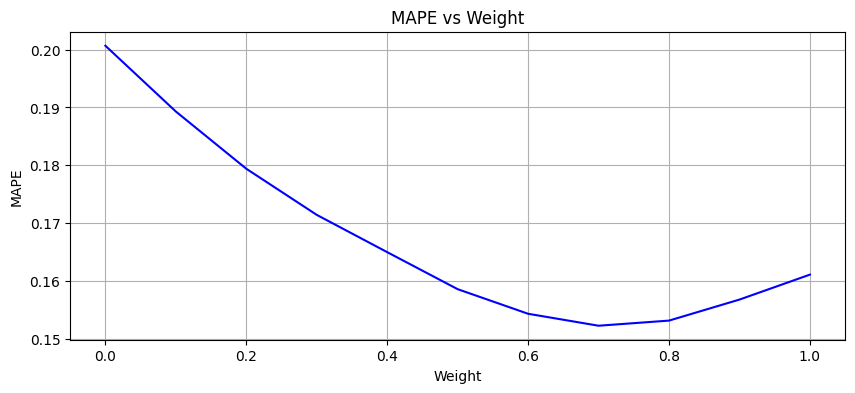

In [ ]:
weights_list = np.arange(0, 1.1, 0.1).tolist()
mape_list_book1 = []
for weight in weights_list:
    #parallel_forecast = (1-weight)*forecast_ARIMA + weight*comparison_book1['LSTM Forecast'].iloc[-n_forecast_periods:]
    parallel_forecast = (1-weight)*forecast_ARIMA + weight*pd.Series(y_pred_na_book1,index=ts_book1_test.index).iloc[-n_forecast_periods:]
    mape_list_book1.append(mean_absolute_percentage_error(comparison_book1['Test'].iloc[-n_forecast_periods:].to_numpy(), parallel_forecast))

min_index = mape_list_book1.index(min(mape_list_book1))
print("The best weight is", weights_list[min_index], "and the lowest mape is", mape_list_book1[min_index])
plt.figure(figsize=(10, 4))
plt.plot(weights_list, mape_list_book1, color='blue')
plt.xlabel("Weight")
plt.ylabel("MAPE")
plt.title("MAPE vs Weight")
plt.grid(True)
plt.show()

The final hybrid forecast is constructed using the optimal blending weight. The actual test data and forecasts from the ARIMA, LSTM, and hybrid models are plotted for comparative visualization. The Mean Absolute Error (MAE) and MAPE of the final hybrid forecast are computed and reported to quantify predictive performance.

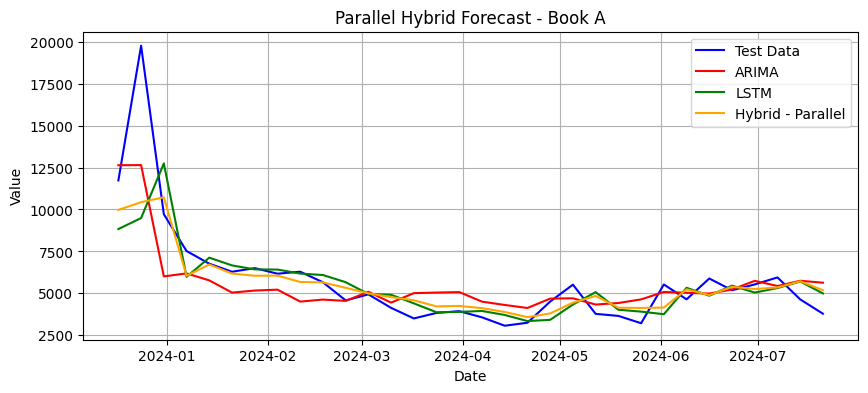

mae 957.4565272394216
mape 0.15225856042455277


In [ ]:
weight = weights_list[min_index]
parallel_forecast = (1-weight)*forecast_ARIMA + weight*pd.Series(y_pred_na_book1,index=ts_book1_test.index).iloc[-n_forecast_periods:]

# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_book1_test, label="Test Data", color="blue")
plt.plot(forecast_ARIMA, label="ARIMA", color="red")
plt.plot(pd.Series(y_pred_na_book1,index=ts_book1_test.index).iloc[-n_forecast_periods:], label="LSTM", color="green")
plt.plot(parallel_forecast, label="Hybrid - Parallel", color="orange")
plt.title("Parallel Hybrid Forecast - Book A")
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

mae_hybrid_parallel_book1 = mean_absolute_error(comparison_book1['Test'].iloc[-n_forecast_periods:].to_numpy(), parallel_forecast)
mape_hybrid_parallel_book1 = mean_absolute_percentage_error(comparison_book1['Test'].iloc[-n_forecast_periods:].to_numpy(), parallel_forecast)
print("mae", mae_hybrid_parallel_book1)
print("mape", mape_hybrid_parallel_book1)

In [ ]:
summary_book_1['Hybrid - P'] = [mae_hybrid_parallel_book1, round(mape_hybrid_parallel_book1*100, 2)]

**Book 2**:

The same steps are repeated for book 2

In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr_book2, conf_int_arr = autoarima_model_2.predict(n_periods=n_forecast_periods, return_conf_int=True)

# Step 2: Ensure index alignment
forecast_index = ts_book2_test.index

# Step 3: Create numeric Series/DataFrames with clean data
forecast_ARIMA_book2 = pd.Series(forecast_arr_book2, index=forecast_index)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


The best weight is 0.5 and the lowest mape is 0.14750090746425962


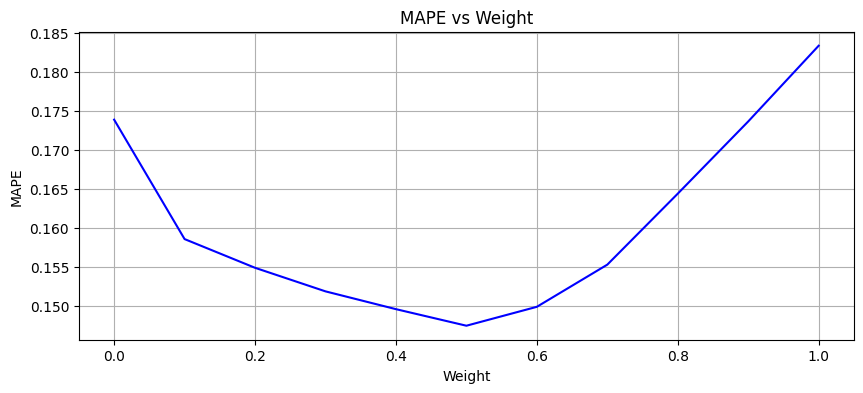

In [ ]:
weights_list = np.arange(0, 1.1, 0.1).tolist()
mape_list_book2 = []
for weight in weights_list:
    parallel_forecast = (1-weight)*forecast_ARIMA_book2 + weight*pd.Series(y_pred_na_book2,index=ts_book2_test.index).iloc[-n_forecast_periods:]
    mape_list_book2.append(mean_absolute_percentage_error(comparison_book2['Test'].iloc[-n_forecast_periods:].to_numpy(), parallel_forecast))

min_index = mape_list_book2.index(min(mape_list_book2))
print("The best weight is", weights_list[min_index], "and the lowest mape is", mape_list_book2[min_index])

plt.figure(figsize=(10, 4))
plt.plot(weights_list, mape_list_book2, color='blue')
plt.xlabel("Weight")
plt.ylabel("MAPE")
plt.title("MAPE vs Weight")
plt.grid(True)
plt.show()

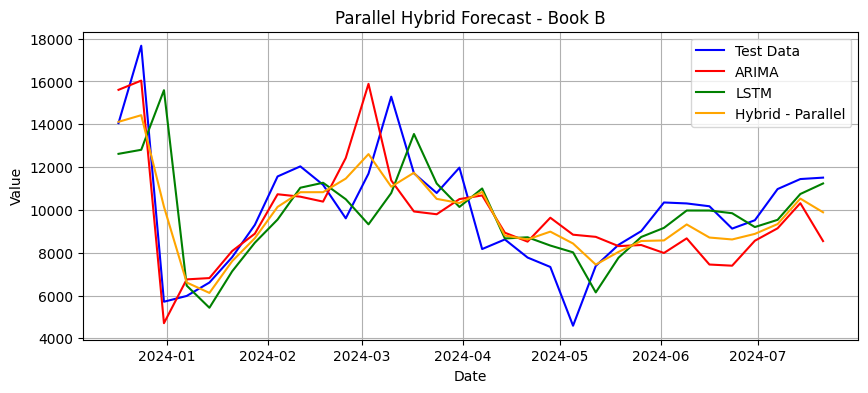

mae 1285.4153327624867
mape 0.14750090746425962


In [ ]:
weight = weights_list[min_index]
parallel_forecast = (1-weight)*forecast_ARIMA_book2 + weight*pd.Series(y_pred_na_book2,index=ts_book2_test.index).iloc[-n_forecast_periods:]

# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_book2_test, label="Test Data", color="blue")
plt.plot(forecast_ARIMA_book2, label="ARIMA", color="red")
plt.plot(pd.Series(y_pred_na_book2,index=ts_book2_test.index).iloc[-n_forecast_periods:], label="LSTM", color="green")
plt.plot(parallel_forecast, label="Hybrid - Parallel", color="orange")
plt.title("Parallel Hybrid Forecast - Book B")
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

mae_hybrid_parallel_book2 = mean_absolute_error(comparison_book2['Test'].iloc[-n_forecast_periods:].to_numpy(), parallel_forecast)
mape_hybrid_parallel_book2 = mean_absolute_percentage_error(comparison_book2['Test'].iloc[-n_forecast_periods:].to_numpy(), parallel_forecast)
print("mae", mae_hybrid_parallel_book2)
print("mape", mape_hybrid_parallel_book2)

In [ ]:
summary_book_2['Hybrid - P'] = [mae_hybrid_parallel_book2, round(mape_hybrid_parallel_book2*100, 2)]

In [ ]:
summary_book_1

,ARIMA,XGBoost HO,XGBoost GS,LSTM,LSTM - 2,Hybrid - s,Hybrid - P
MAE,1157.135013,1093.814835,1152.106485,1208.158583,1097.978134,1147.641788,957.456527
MAPE [%],20.070000,16.390000,19.070000,21.150000,16.110000,19.770000,15.230000


A comparison of all prediction algorithms performance is then provided in the cells below

<Axes: ylabel='MAPE [%]'>

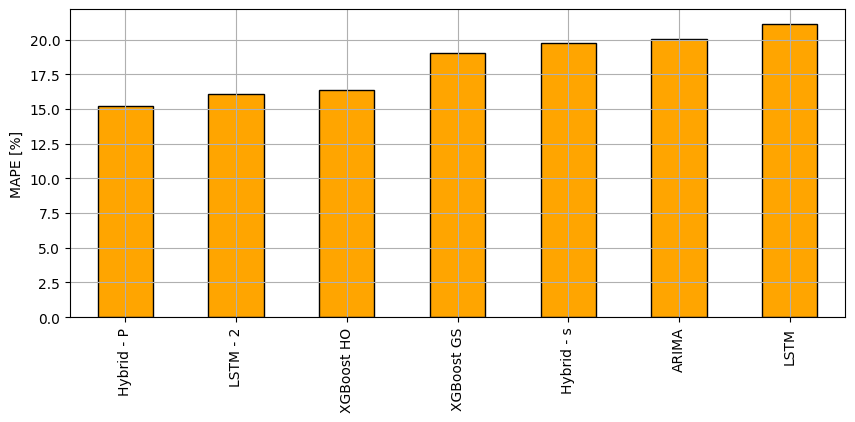

In [ ]:
summary_book_1.iloc[1,:].sort_values().plot(kind='bar',ylabel='MAPE [%]',grid=True, color='orange', edgecolor='black',figsize=(10,4))

In [ ]:
summary_book_2

,ARIMA,XGBoost HO,XGBoost GS,LSTM,LSTM - 2,Hybrid - S,Hybrid - P
MAE,1612.048335,1616.165081,1883.042147,4371.27631,1557.638849,1632.500144,1285.415333
MAPE [%],17.390000,16.790000,18.100000,44.15000,18.340000,17.590000,14.750000


<Axes: ylabel='MAPE [%]'>

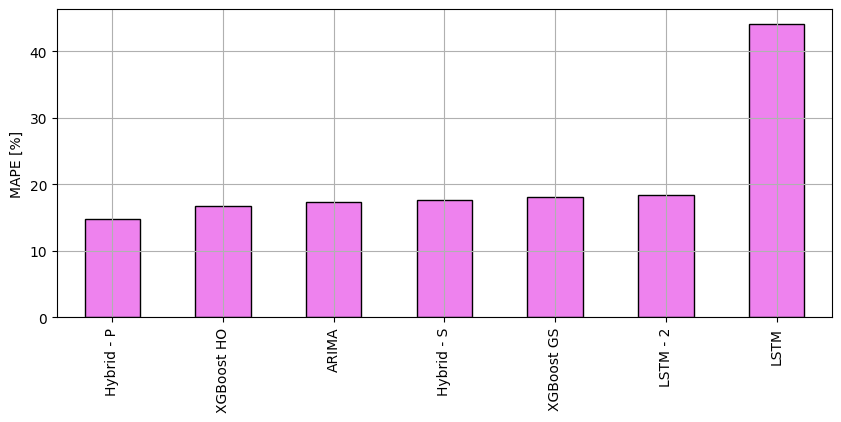

In [ ]:
summary_book_2.iloc[1,:].sort_values().plot(kind='bar',ylabel='MAPE [%]',grid=True, color='violet', edgecolor='black',figsize=(10,4))

### Monthly Part

The data for the two books is re-sampled with monthly frequency. As before, missing values are filled with 0 as it means no sales happened on that specific time period.

/tmp/ipython-input-2567407847.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_book1_monthly = ts_book1_monthly.resample('M').sum().fillna(0)
/tmp/ipython-input-2567407847.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_book2_monthly = ts_book2_monthly.resample('M').sum().fillna(0)


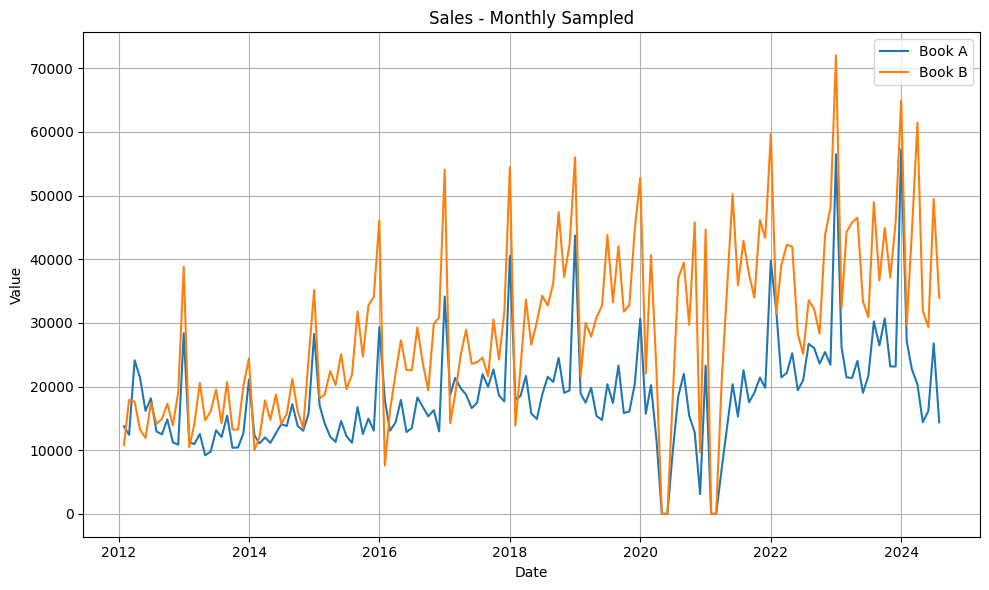

In [ ]:
ts_book1_monthly = uk_weekly_trend_allsheets[(uk_weekly_trend_allsheets['ISBN'] == ISBN_Book_A) & (uk_weekly_trend_allsheets.index > pd.to_datetime('2012-01-01'))]['Value']
ts_book1_monthly = ts_book1_monthly.resample('M').sum().fillna(0)
ts_book2_monthly = uk_weekly_trend_allsheets[(uk_weekly_trend_allsheets['ISBN'] == ISBN_Book_B) & (uk_weekly_trend_allsheets.index > pd.to_datetime('2012-01-01'))]['Value']
ts_book2_monthly = ts_book2_monthly.resample('M').sum().fillna(0)

plt.figure(figsize=(10, 6))
plt.plot(ts_book1_monthly)
plt.plot(ts_book2_monthly)
plt.title("Sales - Monthly Sampled")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(['Book A','Book B'])
plt.grid(True)
plt.tight_layout()
plt.show()

Train and test datasets for both books are defined, setting the time index as "Period" as required by the XGBoost algorithm

In [ ]:
n_forecast_periods = 8
###
ts_book1_monthly_xgb = ts_book1_monthly.copy()
ts_book2_monthly_xgb = ts_book2_monthly.copy()
###
ts_book1_monthly_train = ts_book1_monthly[:-n_forecast_periods]
ts_book1_monthly_test = ts_book1_monthly[-n_forecast_periods:]
ts_book2_monthly_train = ts_book2_monthly[:-n_forecast_periods]
ts_book2_monthly_test = ts_book2_monthly[-n_forecast_periods:]
###
ts_book1_monthly_train_xgb = ts_book1_monthly_xgb[:-n_forecast_periods]
ts_book1_monthly_test_xgb = ts_book1_monthly_xgb[-n_forecast_periods:]
ts_book2_monthly_train_xgb = ts_book2_monthly_xgb[:-n_forecast_periods]
ts_book2_monthly_test_xgb = ts_book2_monthly_xgb[-n_forecast_periods:]
###
ts_book1_monthly_train_xgb.index = pd.PeriodIndex(ts_book1_monthly_train_xgb.index, freq="M")
ts_book1_monthly_test_xgb.index = pd.PeriodIndex(ts_book1_monthly_test_xgb.index, freq="M")
ts_book2_monthly_train_xgb.index = pd.PeriodIndex(ts_book2_monthly_train_xgb.index, freq="M")
ts_book2_monthly_test_xgb.index = pd.PeriodIndex(ts_book2_monthly_test_xgb.index, freq="M")

An Auto-Arima model is fit to book 1 monthly data

In [ ]:

warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

# Fit Auto ARIMA model to ts_train with specified bounds
autoarima_model_1_monthly = auto_arima(
    y=ts_book1_monthly_train,
    m=12,                    # seasonal period = 12 months
    )

# Print model summary
print(autoarima_model_1_monthly.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  143
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 12)   Log Likelihood               -1430.368
Date:                              Sun, 24 Aug 2025   AIC                           2872.736
Time:                                      13:07:58   BIC                           2890.471
Sample:                                  01-31-2012   HQIC                          2879.943
                                       - 11-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -487.7988    372.784     -1.309      0.191   -1218.442     242.845
ar.L1         -0.31

Hyperparameter tuning for the XGBoost model is conducted via grid search on the monthly dataset, following the same procedure previously applied to the weekly dataset

In [ ]:

param_grid_monthly = {
    "forecast__window_length": [12, 18, 24, 36, 48, 60],  # 1x, 1.5x, 2x seasonal period
    "forecast__estimator__n_estimators": [100, 200, 300, 400],
    "forecast__estimator__max_depth": [3, 5, 7, 9],
    "forecast__estimator__learning_rate": [0.01, 0.05, 0.1, 0.2]
}


In [ ]:
"""
predictor_monthly = create_predictor_with_deseasonaliser_xgboost(sp=12)
# Perform a grid search.
predictions_book1_monthly, best_model = grid_search_predictor(
    ts_book1_monthly_train_xgb, ts_book1_monthly_test_xgb, predictor_monthly, param_grid_monthly
)
"""

'\npredictor_monthly = create_predictor_with_deseasonaliser_xgboost(sp=12)\n# Perform a grid search.\npredictions_book1_monthly, best_model = grid_search_predictor(\n    ts_book1_monthly_train_xgb, ts_book1_monthly_test_xgb, predictor_monthly, param_grid_monthly\n)\n'

In this block, tuned models for both books are either saved to .pkl files or reuploaded in order to avoid re-running them every time.

In [ ]:
# Save
#predictions_book1_monthly.to_pickle("Predictions_Monthly_XGBoost_Book1.pkl")
#predictions_book2_monthly.to_pickle("Predictions_Monthly_XGBoost_Book2.pkl")

# Load latermodel_path+'Book_1_ARIMA_model.pkl'
predictions_book1_monthly = pd.read_pickle(model_path+"Predictions_Monthly_XGBoost_Book1.pkl")
predictions_book2_monthly = pd.read_pickle(model_path+"Predictions_Monthly_XGBoost_Book2.pkl")

In [ ]:
predictions_book1_monthly.shape

(8,)

A comparison between ARIMA and XGBoost results for book 1 is provided

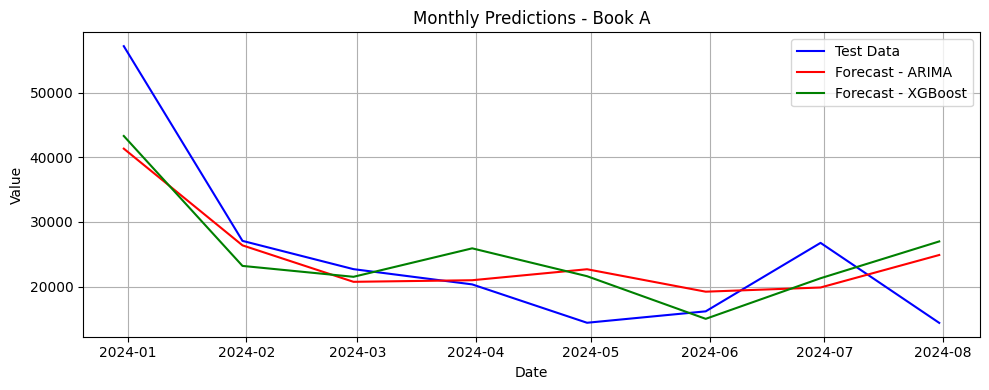

mae 6379.838476379253
mape 0.29620751095753084
mae 5993.088957807836
mape 0.27203078064862063


,ARIMA,XGBoost
MAE,5993.088958,6379.838476
MAPE [%],27.200000,29.620000


In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr, conf_int_arr = autoarima_model_1_monthly.predict(n_periods=n_forecast_periods, return_conf_int=True)

# Step 2: Ensure index alignment
forecast_index = ts_book1_monthly_test.index

# Step 3: Create numeric Series/DataFrames with clean data
forecast = pd.Series(forecast_arr, index=forecast_index)
conf_int = pd.DataFrame(conf_int_arr, columns=["Lower", "Upper"], index=forecast_index)

# Step 4: Force float types + drop NaNs (optional safety net)
forecast = forecast.astype(float)
conf_int = conf_int.astype(float)

forecast = forecast.dropna()
conf_int = conf_int.dropna()

# Step 5: Plot
plt.figure(figsize=(10, 4))
#plt.plot(ts_book1_train_subset, label="Training Data", color="black")
plt.plot(ts_book1_monthly_test.index, ts_book1_monthly_test.values, label="Test Data", color="blue")
plt.plot(forecast, label="Forecast - ARIMA", color="red")
plt.plot(ts_book1_monthly_test.index, predictions_book1_monthly.values, label="Forecast - XGBoost", color="green")


plt.title("Monthly Predictions - Book A")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("mae", mean_absolute_error(ts_book1_monthly_test.values, predictions_book1_monthly))
print("mape", mean_absolute_percentage_error(ts_book1_monthly_test.values, predictions_book1_monthly))
print("mae", mean_absolute_error(ts_book1_monthly_test.values, forecast))
print("mape", mean_absolute_percentage_error(ts_book1_monthly_test.values, forecast))

summary_book_1_monthly = pd.DataFrame(columns=['ARIMA', 'XGBoost'],index=['MAE','MAPE [%]'])
summary_book_1_monthly['ARIMA'] = [mean_absolute_error(ts_book1_monthly_test.values, forecast), round(mean_absolute_percentage_error(ts_book1_monthly_test.values, forecast)*100, 2)]
summary_book_1_monthly['XGBoost'] = [mean_absolute_error(ts_book1_monthly_test.values, predictions_book1_monthly), round(mean_absolute_percentage_error(ts_book1_monthly_test.values, predictions_book1_monthly)*100, 2)]
summary_book_1_monthly

The same steps are repeated for "Book B"

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning, message=".*force_all_finite.*")

# Fit Auto ARIMA model to ts_train with specified bounds
autoarima_model_2_monthly = auto_arima(
    y=ts_book2_monthly_train,
    m=12,                    # seasonal period = 52 weeks
    )

# Print model summary
print(autoarima_model_2_monthly.summary())

/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,2)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_p

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1494.993
Date:                            Sun, 24 Aug 2025   AIC                           2999.987
Time:                                    13:11:00   BIC                           3014.766
Sample:                                01-31-2012   HQIC                          3005.992
                                     - 11-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4190      0.063      6.652      0.000       0.296       0.542
ma.L1         -0.9580      0.026   

In [ ]:
param_grid_monthly = {
    "forecast__window_length": [12, 18, 24, 36, 48, 60],  # 1x, 1.5x, 2x seasonal period
    "forecast__estimator__n_estimators": [100, 200, 300, 400],
    "forecast__estimator__max_depth": [3, 5, 7, 9],
    "forecast__estimator__learning_rate": [0.01, 0.05, 0.1, 0.2]
}

In [ ]:
"""
# Perform a grid search.
predictions_book2_monthly, best_model = grid_search_predictor(
    ts_book2_monthly_train_xgb, ts_book2_monthly_test_xgb, predictor_monthly, param_grid_monthly
)
"""

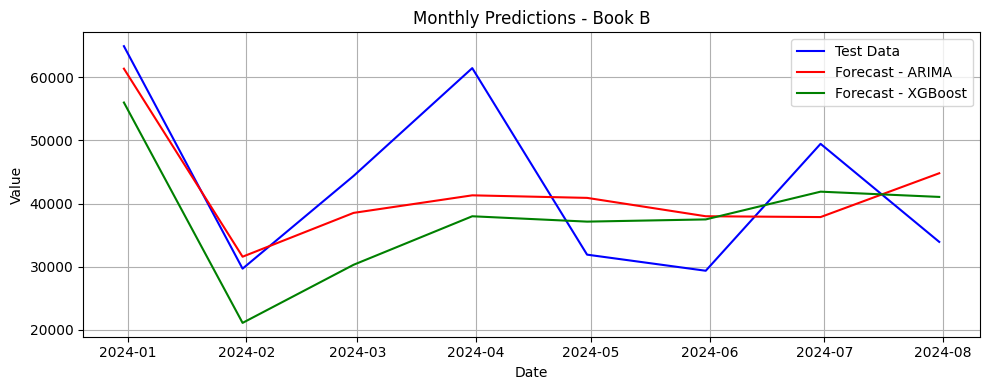

mae 10394.525388604443
mape 0.24136123559687567
mae 8949.716323222954
mape 0.2138047471361423


,ARIMA,XGBoost
MAE,8949.716323,10394.525389
MAPE [%],21.380000,24.136000


In [ ]:
# Step 1: Generate forecast and conf_int from auto_arima
forecast_arr, conf_int_arr = autoarima_model_2_monthly.predict(n_periods=n_forecast_periods, return_conf_int=True)

# Step 2: Ensure index alignment
forecast_index = ts_book2_monthly_test.index

# Step 3: Create numeric Series/DataFrames with clean data
forecast = pd.Series(forecast_arr, index=forecast_index)
conf_int = pd.DataFrame(conf_int_arr, columns=["Lower", "Upper"], index=forecast_index)

# Step 4: Force float types + drop NaNs (optional safety net)
forecast = forecast.astype(float)
conf_int = conf_int.astype(float)

forecast = forecast.dropna()
conf_int = conf_int.dropna()

# Step 5: Plot
plt.figure(figsize=(10, 4))
#plt.plot(ts_book1_train_subset, label="Training Data", color="black")
plt.plot(ts_book2_monthly_test.index, ts_book2_monthly_test.values, label="Test Data", color="blue")
plt.plot(forecast, label="Forecast - ARIMA", color="red")
plt.plot(ts_book2_monthly_test.index, predictions_book2_monthly.values, label="Forecast - XGBoost", color="green")


plt.title("Monthly Predictions - Book B")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("mae", mean_absolute_error(ts_book2_monthly_test.values, predictions_book2_monthly))
print("mape", mean_absolute_percentage_error(ts_book2_monthly_test.values, predictions_book2_monthly))
print("mae", mean_absolute_error(ts_book2_monthly_test.values, forecast))
print("mape", mean_absolute_percentage_error(ts_book2_monthly_test.values, forecast))

summary_book_2_monthly = pd.DataFrame(columns=['ARIMA', 'XGBoost'],index=['MAE','MAPE [%]'])
summary_book_2_monthly['ARIMA'] = [mean_absolute_error(ts_book2_monthly_test.values, forecast), round(mean_absolute_percentage_error(ts_book2_monthly_test.values, forecast)*100, 3)]
summary_book_2_monthly['XGBoost'] = [mean_absolute_error(ts_book2_monthly_test.values, predictions_book2_monthly), round(mean_absolute_percentage_error(ts_book2_monthly_test.values, predictions_book2_monthly)*100, 3)]
summary_book_2_monthly